<a href="https://www.kaggle.com/code/jonathanradcliffe/2nd-notbook-ames-house-price?scriptVersionId=124532071" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# House Prices: First Go!

# Table of contents
   1. [Introduction](#introduction)
   2. [Exploring the test data](#paragraph1)
   3. [Missing data](#paragraph2)
   4. [EDA, Outliers, Feature Engineering](#paragraph3)
       1. [Let's look closely at our target and most significant features](#subparagraph1)
       2. [Log Transform SalePrice](#subparagraph2)
       3. [Feature engineering](#subparagraph3)
       4. [Assess numerical features skewness](#subparagraph4)
   5. [OneHotEncoding for catagorical features](#paragraph4)
   6. [Initial screening of regression algorithms](#paragraph5)
   7. [Optimization of best models](#paragraph6)
   8. [Predict test SalePrice!](#paragraph7)

# Introduction
## This is the introduction <a name="introduction"></a>
This is my second notebook for the request to predict sales prices for residential homes in Ames, Iowa. Keen to see what new approaches I take after completing four kaggle getting-started competitions. This train dataset has 79 features along withe the saleprice. The test dataset contains the 79 features and we will predict the saleprice using the model made from the train dataset. 
We will proceed as follows: 
* Read-in and understand the two dataframes
* Clarify what data is missing and determine how we willl deal with the missing data.
* Perform EDA to understand the data, look for outliers and decide which features may require feature engineering. 
* Scale and transform continuous features if required
* OneHotEncode catagorical features
* Initial screening of regression algorithms
* Optimization of down-selected algoriths
* Build pipeline for final model
* Predict saleprice for test dataframe

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


Import Libraries

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from scipy.stats import norm, skew

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 5000)
pd.set_option('display.max_rows', 5000)

# Read-in datasets
## Exploring the test data <a name="paragraph1"></a>


In [3]:
# Load the data set
train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
sample_submission = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv')

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [5]:
train.dtypes.value_counts()

object     43
int64      35
float64     3
dtype: int64

Lots of features. Looks like more than half will be catagorical. We will determine if any continuous features become catagorical during EDA.

In [6]:
print(train.shape)
print(test.shape)

(1460, 81)
(1459, 80)


Unfortunately, not very many observations so cross validation will be important

# Let's see what data is missing and decide how to proceed
## What's missing? <a name="paragraph2"></a>

In [7]:
df = train.drop(['SalePrice'], axis=1)
df = pd.concat([df, test], ignore_index=True) 
print(df.shape)

(2919, 80)


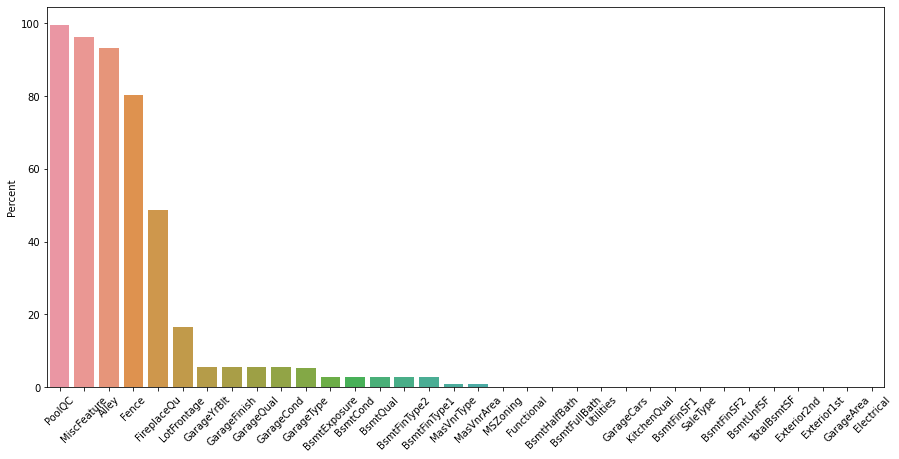

In [8]:
missing_vals = pd.DataFrame(df.isna().sum(), columns=['Sum'])
missing_vals = missing_vals.sort_values(by = ['Sum'], ascending=False)
missing_vals = missing_vals[missing_vals['Sum']>0]
missing_vals['Percent'] = missing_vals['Sum']/2920*100

plt.figure(figsize = (15, 7))
sns.barplot(x= missing_vals.index, y=missing_vals['Percent'])
plt.xticks(rotation=45)
plt.show()

<AxesSubplot:xlabel='Alley', ylabel='SalePrice'>

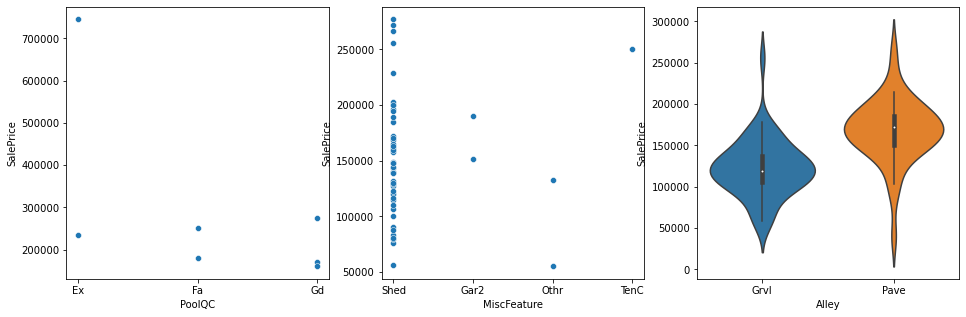

In [9]:
fig, ax = plt.subplots(1,3, figsize =(16, 5))
sns.scatterplot(x= train['PoolQC'], y=train['SalePrice'], ax=ax[0])
sns.scatterplot(x= train['MiscFeature'], y=train['SalePrice'], ax=ax[1])
sns.violinplot(x= train['Alley'], y=train['SalePrice'], ax=ax[2])

* According to the data description all missing data for these features likely means the feature isn't present. As such Nan is replaced with 'none'
* Looks like there is in increase in SalePrice with Pave over Gravel for Alley. 
* Plenty of Shed data. what is othr? Think I'll bin Othr. I think i'll creat 3 new features and bin MisFeature. 2 catagorical (Gar2, TenC) and one continuous Shed
* PoolQC again has limited data little in the way of trend. 

<AxesSubplot:xlabel='LotFrontage', ylabel='SalePrice'>

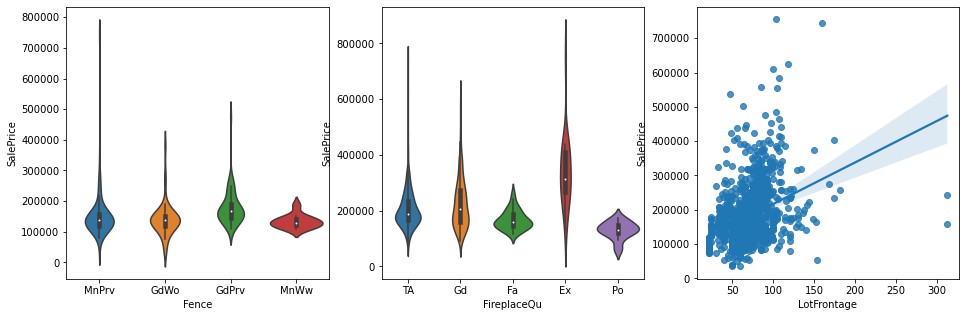

In [10]:
fig, ax = plt.subplots(1,3, figsize =(16, 5))
sns.violinplot(x= train['Fence'], y=train['SalePrice'], ax=ax[0])
sns.violinplot(x= train['FireplaceQu'], y=train['SalePrice'], ax=ax[1])
sns.regplot(x= train['LotFrontage'], y=train['SalePrice'], ax=ax[2])

* According to the data description all missing data for these features likely means the feature isn't present. As such Nan is replaced with 'none'
* we might need to keep an eye on those outliers at high LotFrontage >300.

Normally I'd drop anything with more than 15% of the data missing, however we have identified a lot of the missing data as the feature isn't present. 
* PoolQC (missing data likely none)
* MiscFeature (missing data likely none), however there is so little data for anything except shed that I'm going to keep it alone.
* Alley (missing data likely non)
* Fence (missing data likely none)
* Fireplace Qu (missing data likely none)
* LotFrontage (missing data likely 0). 

In [11]:
cols1 = ['PoolQC', 'Alley', 'Fence', 'FireplaceQu']
df[cols1] = df[cols1].fillna('none')

In [12]:
df['LotFrontage'] = df['LotFrontage'].fillna(0)

In [13]:
df['Shed'] = 0 
df.loc[df['MiscFeature'] == 'Shed','Shed'] = 1
df = df.drop(['MiscFeature'], axis=1)

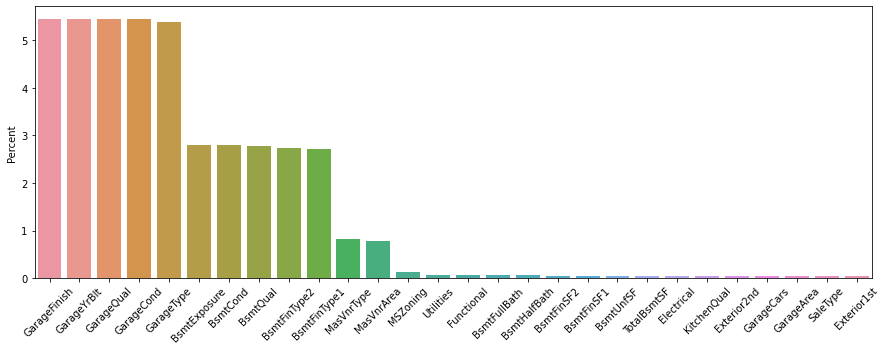

In [14]:
missing_vals = pd.DataFrame(df.isna().sum(), columns=['Sum'])
missing_vals = missing_vals.sort_values(by = ['Sum'], ascending=False)
missing_vals = missing_vals[missing_vals['Sum']>0]
missing_vals['Percent'] = missing_vals['Sum']/2920*100

plt.figure(figsize = (15, 5))
sns.barplot(x= missing_vals.index, y=missing_vals['Percent'])
plt.xticks(rotation=45)
plt.show()

**Let's next look at the 5 Garage features with the highest missing data by percentage**

GarageFinish: Interior finish of the garage. Fin	Finished; RFn	Rough Finished; Unf	Unfinished;  NA	No Garage

GarageYrBlt: Year garage was built

GarageQual: Garage quality. Ex	Excellent; Gd	Good; TA	Typical/Average; Fa	Fair; Po	Poor; NA	No Garage

GarageCond: Garage condition. Ex	Excellent; Gd	Good; TA	Typical/Average; Fa	Fair; Po	Poor; NA	No Garage

GarageType: Garage location. 2Types	More than one type of garage; Attchd	Attached to home; Basment	Basement Garage; BuiltIn	Built-In (Garage part of house - typically has room above garage); CarPort	Car Port; Detchd	Detached from home; NA	No Garage

In [15]:
cols_garage = ['GarageFinish', 'GarageYrBlt','GarageQual', 'GarageCond', 'GarageType']
train[cols_garage].isnull().sum()

GarageFinish    81
GarageYrBlt     81
GarageQual      81
GarageCond      81
GarageType      81
dtype: int64

Looks like all of cols_garage have the same number of missing data. Let's replace them appropriately with none (careful with GarageYrBlt as that has integers so we will deal with this later)

In [16]:
cols_garage = ['GarageFinish','GarageQual', 'GarageCond', 'GarageType']
df[cols_garage] = df[cols_garage].fillna('none')

**Let's next look at the 5 Basement features with the highest missing data by percentage**

BsmtExposure: Refers to walkout or garden level walls. Gd	Good Exposure; Av	Average Exposure (split levels or foyers typically score average or above); Mn	Mimimum Exposure; No	No Exposure; NA	No Basement

BsmtCond: Evaluates the general condition of the basement. Ex	Excellent; Gd	Good; TA	Typical - slight dampness allowed; Fa	Fair - dampness or some cracking or settling; Po	Poor - Severe cracking, settling, or wetness; NA	No Basement

BsmtQual: Evaluates the height of the basement. Ex	Excellent (100+ inches); Gd	Good (90-99 inches); TA	Typical (80-89 inches); Fa	Fair (70-79 inches); Po	Poor (<70 inches); NA	No Basement

BsmtFinType2: Rating of basement finished area (if multiple types). GLQ	Good Living Quarters; ALQ	Average Living Quarters; BLQ	Below Average Living Quarters; Rec	Average Rec Room; LwQ	Low Quality; Unf	Unfinshed; NA	No Basement

BsmtFinType1: Rating of basement finished area. GLQ	Good Living Quarters; ALQ	Average Living Quarters; BLQ	Below Average Living Quarters; Rec	Average Rec Room; LwQ	Low Quality; Unf	Unfinshed; NA	No Basement

In [17]:
cols_bsmt = ['BsmtExposure', 'BsmtCond','BsmtQual', 'BsmtFinType2', 'BsmtFinType1']
train[cols_bsmt].isnull().sum()

BsmtExposure    38
BsmtCond        37
BsmtQual        37
BsmtFinType2    38
BsmtFinType1    37
dtype: int64

In [18]:
df[cols_bsmt] = df[cols_bsmt].fillna('none')

**Let's look at the next three missing the most data by percentage**

MasVnrType: Masonry veneer type. BrkCmn	Brick Common; BrkFace	Brick Face; CBlock	Cinder Block; None	None; Stone	Stone

MasVnrArea: Masonry veneer area in square feet

MSZoning: Identifies the general zoning classification of the sale. A	Agriculture; C	Commercial; FV	Floating Village Residential; I	Industrial; RH	Residential High Density; RL	Residential Low Density; RP	Residential Low Density Park; RM	Residential Medium Density

In [19]:
df[['MasVnrType', 'MasVnrArea', 'MSZoning']].isnull().sum()

MasVnrType    24
MasVnrArea    23
MSZoning       4
dtype: int64

In [20]:
df['MasVnrType'].value_counts()

None       1742
BrkFace     879
Stone       249
BrkCmn       25
Name: MasVnrType, dtype: int64

<AxesSubplot:xlabel='MasVnrArea', ylabel='Density'>

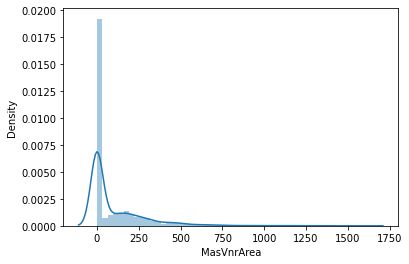

In [21]:
sns.distplot(df['MasVnrArea'])

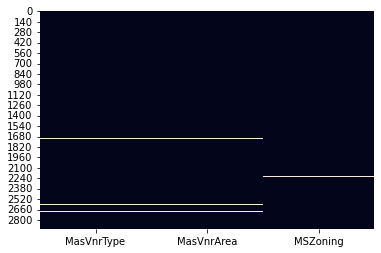

In [22]:
sns.heatmap(df[['MasVnrType', 'MasVnrArea', 'MSZoning']].isnull(),cbar=False)
plt.show()

In [23]:
df['MSZoning'].value_counts()

RL         2265
RM          460
FV          139
RH           26
C (all)      25
Name: MSZoning, dtype: int64

From the data I will replace MasVnrType and MasVnrArea with the most frequent - none and 0. 
For MSZoning I will replace with the most frequent - RL.

In [24]:
df['MasVnrType'] = df['MasVnrType'].fillna('None')
df['MasVnrArea'] = df['MasVnrArea'].fillna(0)
df['MSZoning'] = df['MSZoning'].fillna('RL')

**Let's look at the next four missing the most data by percentage**

BsmtFullBath: Basement full bathrooms

BsmtHalfBath: Basement half bathrooms

Functional: Home functionality (Assume typical unless deductions are warranted). Typ	Typical Functionality; Min1	Minor Deductions 1; Min2	Minor Deductions 2; Mod	Moderate Deductions; Maj1	Major Deductions 1; Maj2	Major Deductions 2; Sev	Severely Damaged; Sal	Salvage only

Utilities: Type of utilities available; AllPub	All public Utilities (E,G,W,& S); NoSewr	Electricity, Gas, and Water (Septic Tank); NoSeWa	Electricity and Gas Only; ELO	Electricity only

In [25]:
df[['BsmtFullBath', 'BsmtHalfBath', 'Functional', 'Utilities']].isnull().sum()

BsmtFullBath    2
BsmtHalfBath    2
Functional      2
Utilities       2
dtype: int64

In [26]:
df[['BsmtFullBath', 'BsmtHalfBath', 'Functional', 'Utilities']].value_counts()

BsmtFullBath  BsmtHalfBath  Functional  Utilities
0.0           0.0           Typ         AllPub       1431
1.0           0.0           Typ         AllPub       1084
0.0           1.0           Typ         AllPub        140
              0.0           Min2        AllPub         40
2.0           0.0           Typ         AllPub         35
0.0           0.0           Min1        AllPub         30
1.0           0.0           Min1        AllPub         29
0.0           0.0           Mod         AllPub         25
1.0           0.0           Min2        AllPub         21
              1.0           Typ         AllPub         19
0.0           0.0           Maj1        AllPub         12
1.0           0.0           Mod         AllPub          9
0.0           1.0           Min2        AllPub          7
1.0           0.0           Maj1        AllPub          6
0.0           0.0           Maj2        AllPub          6
              1.0           Min1        AllPub          4
1.0           0.0     

In [27]:
df.loc[(df['BsmtFullBath'].isnull()) | (df['BsmtHalfBath'].isnull()) | (df['Functional'].isnull()) | (df['Utilities'].isnull())]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,Shed
1915,1916,30,RL,109.0,21780,Grvl,none,Reg,Lvl,NaN,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1Story,2,4,1910,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,Fa,Fa,CBlock,none,none,none,none,0.0,none,0.0,0.0,0.0,GasA,TA,N,FuseA,810,0,0,810,0.0,0.0,1,0,1,1,TA,4,Min1,0,none,Detchd,1975.0,Unf,1.0,280.0,TA,TA,N,119,24,0,0,0,0,none,none,0,3,2009,ConLD,Normal,0
1945,1946,20,RL,0.0,31220,Pave,none,IR1,Bnk,NaN,FR2,Gtl,Gilbert,Feedr,Norm,1Fam,1Story,6,2,1952,1952,Hip,CompShg,BrkFace,BrkFace,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,1632.0,1632.0,GasA,TA,Y,FuseA,1474,0,0,1474,0.0,0.0,1,0,3,1,TA,7,Min2,2,Gd,Attchd,1952.0,Unf,2.0,495.0,TA,TA,Y,0,0,144,0,0,0,none,none,750,5,2008,WD,Normal,1
2120,2121,20,RM,99.0,5940,Pave,none,IR1,Lvl,AllPub,FR3,Gtl,BrkSide,Feedr,Norm,1Fam,1Story,4,7,1946,1950,Gable,CompShg,MetalSd,CBlock,None,0.0,TA,TA,PConc,none,none,none,none,NaN,none,NaN,NaN,NaN,GasA,TA,Y,FuseA,896,0,0,896,NaN,NaN,1,0,2,1,TA,4,Typ,0,none,Detchd,1946.0,Unf,1.0,280.0,TA,TA,Y,0,0,0,0,0,0,none,MnPrv,0,4,2008,ConLD,Abnorml,0
2188,2189,20,RL,123.0,47007,Pave,none,IR1,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,5,7,1959,1996,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,Slab,none,none,none,none,0.0,none,0.0,0.0,0.0,GasA,TA,Y,SBrkr,3820,0,0,3820,NaN,NaN,3,1,5,1,Ex,11,Typ,2,Gd,Attchd,1959.0,Unf,2.0,624.0,TA,TA,Y,0,372,0,0,0,0,none,none,0,7,2008,WD,Normal,0
2216,2217,20,RL,80.0,14584,Pave,none,Reg,Low,AllPub,Inside,Mod,IDOTRR,Norm,Norm,1Fam,1Story,1,5,1952,1952,Gable,CompShg,AsbShng,VinylSd,None,0.0,Fa,Po,Slab,none,none,none,none,0.0,none,0.0,0.0,0.0,Wall,Po,N,FuseA,733,0,0,733,0.0,0.0,1,0,2,1,Fa,4,NaN,0,none,Attchd,1952.0,Unf,2.0,487.0,Fa,Po,N,0,0,0,0,0,0,none,none,0,2,2008,WD,Abnorml,0
2473,2474,50,RM,60.0,10320,Pave,Grvl,Reg,Lvl,AllPub,Corner,Gtl,IDOTRR,Artery,Norm,1Fam,1.5Fin,4,1,1910,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,Fa,Fa,CBlock,TA,Fa,No,Unf,0.0,Unf,0.0,771.0,771.0,GasA,Fa,Y,SBrkr,866,504,114,1484,0.0,0.0,2,0,3,1,TA,6,NaN,0,none,Detchd,1910.0,Unf,1.0,264.0,TA,Fa,N,14,211,0,0,84,0,none,none,0,9,2007,COD,Abnorml,0


Looks like the full and half baths are 0. Not only is this most frequent, the basement features show none for these observations. I'll go with most frequent for other two.

In [28]:
df['BsmtFullBath'] = df['BsmtFullBath'].fillna(0)
df['BsmtHalfBath'] = df['BsmtHalfBath'].fillna(0)
df['Functional'] = df['Functional'].fillna('Typ')
df['Utilities'] = df['Utilities'].fillna('AllPub')

**Let's look at the next four basement missing along with electrical**

BsmtFinSF1: Type 1 finished square feet

BsmtFinSF2: Type 2 finished square feet

BsmtUnfSF: Unfinished square feet of basement area

TotalBsmtSF: Total square feet of basement area

Electrical: Electrical system. SBrkr	Standard Circuit Breakers & Romex; FuseA	Fuse Box over 60 AMP and all Romex wiring (Average); FuseF	60 AMP Fuse Box and mostly Romex wiring (Fair); FuseP	60 AMP Fuse Box and mostly knob & tube wiring (poor); Mix	Mixed

<AxesSubplot:ylabel='Density'>

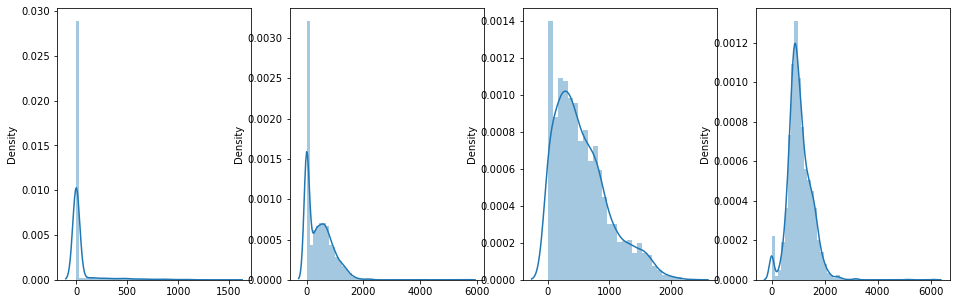

In [29]:
fig, ax = plt.subplots(1,4, figsize =(16, 5))
sns.distplot(x= df['BsmtFinSF2'], ax=ax[0])
sns.distplot(x= df['BsmtFinSF1'], ax=ax[1])
sns.distplot(x= df['BsmtUnfSF'], ax=ax[2])
sns.distplot(x= df['TotalBsmtSF'], ax=ax[3])

In [30]:
df.loc[(df['BsmtFinSF2'].isnull()) | (df['BsmtFinSF1'].isnull()) | (df['BsmtUnfSF'].isnull()) | (df['TotalBsmtSF'].isnull()) | (df['Electrical'].isnull())]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,Shed
1379,1380,80,RL,73.0,9735,Pave,none,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,SLvl,5,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,384.0,384.0,GasA,Gd,Y,NaN,754,640,0,1394,0.0,0.0,2,1,3,1,Gd,7,Typ,0,none,BuiltIn,2007.0,Fin,2.0,400.0,TA,TA,Y,100,0,0,0,0,0,none,none,0,5,2008,WD,Normal,0
2120,2121,20,RM,99.0,5940,Pave,none,IR1,Lvl,AllPub,FR3,Gtl,BrkSide,Feedr,Norm,1Fam,1Story,4,7,1946,1950,Gable,CompShg,MetalSd,CBlock,None,0.0,TA,TA,PConc,none,none,none,none,NaN,none,NaN,NaN,NaN,GasA,TA,Y,FuseA,896,0,0,896,0.0,0.0,1,0,2,1,TA,4,Typ,0,none,Detchd,1946.0,Unf,1.0,280.0,TA,TA,Y,0,0,0,0,0,0,none,MnPrv,0,4,2008,ConLD,Abnorml,0


In [31]:
df['Electrical'].value_counts()

SBrkr    2671
FuseA     188
FuseF      50
FuseP       8
Mix         1
Name: Electrical, dtype: int64

* Replace all Basement with 0. 
* Replace Electrical with most frequent - 2671

In [32]:
df['BsmtFinSF2'] = df['BsmtFinSF2'].fillna(0)
df['BsmtFinSF1'] = df['BsmtFinSF1'].fillna(0)
df['BsmtUnfSF'] = df['BsmtUnfSF'].fillna(0)
df['TotalBsmtSF'] = df['TotalBsmtSF'].fillna(0)
df['Electrical'] = df['Electrical'].fillna('SBrkr')

**Let's look at the Exterior and SaleType**

SaleType: Type of sale. WD 	Warranty Deed - Conventional; CWD	Warranty Deed - Cash; VWD	Warranty Deed - VA Loan; New	Home just constructed and sold; COD	Court Officer Deed/Estate; Con	Contract 15% Down payment regular terms; ConLw	Contract Low Down payment and low interest; ConLI	Contract Low Interest; ConLD	Contract Low Down; Oth	Other

Exterior1st: Exterior covering on house. AsbShng	Asbestos Shingles; AsphShn	Asphalt Shingles; BrkComm	Brick Common; BrkFace	Brick Face; CBlock	Cinder Block; CemntBd	Cement Board; HdBoard	Hard Board; ImStucc	Imitation Stucco; MetalSd	Metal Siding; Other	Other; Plywood	Plywood; PreCast	PreCast; Stone	Stone; Stucco	Stucco; VinylSd	Vinyl Siding; Wd Sdng	Wood Siding; WdShing	Wood Shingles

Exterior2nd: Exterior covering on house. AsbShng	Asbestos Shingles; AsphShn	Asphalt Shingles; BrkComm	Brick Common; BrkFace	Brick Face; CBlock	Cinder Block; CemntBd	Cement Board; HdBoard	Hard Board; ImStucc	Imitation Stucco; MetalSd	Metal Siding; Other	Other; Plywood	Plywood; PreCast	PreCast; Stone	Stone; Stucco	Stucco; VinylSd	Vinyl Siding; Wd Sdng	Wood Siding; WdShing	Wood Shingles

In [33]:
df[['SaleType', 'Exterior1st', 'Exterior2nd']].value_counts()

SaleType  Exterior1st  Exterior2nd
WD        VinylSd      VinylSd        795
          MetalSd      MetalSd        389
          HdBoard      HdBoard        353
          Wd Sdng      Wd Sdng        323
New       VinylSd      VinylSd        185
WD        Plywood      Plywood        172
          CemntBd      CmentBd         88
          BrkFace      BrkFace         41
          HdBoard      Plywood         39
          WdShing      Wd Shng         36
New       CemntBd      CmentBd         33
WD        Stucco       Stucco          31
          AsbShng      AsbShng         30
COD       Wd Sdng      Wd Sdng         20
WD        BrkFace      Wd Sdng         20
COD       HdBoard      HdBoard         19
WD        Plywood      Brk Cmn         18
          Wd Sdng      Plywood         17
COD       MetalSd      MetalSd         17
WD        Wd Sdng      Wd Shng         17
New       MetalSd      MetalSd         15
COD       Plywood      Plywood         11
WD        VinylSd      Wd Shng          9

I'll go with the most frequent (WD, VinylSd, VinylSd)

In [34]:
df['Exterior1st'] = df['Exterior1st'].fillna('VinylSd')
df['Exterior2nd'] = df['Exterior2nd'].fillna('VinylSd')
df['SaleType'] = df['SaleType'].fillna('WD')

**Let's look at the last Garage and KitchenQual**

GarageCars: Size of garage in car capacity

GarageArea: Size of garage in square feet

KitchenQual: Kitchen quality. Ex	Excellent; Gd	Good; TA	Typical/Average; Fa	Fair; Po	Poor

<AxesSubplot:ylabel='Density'>

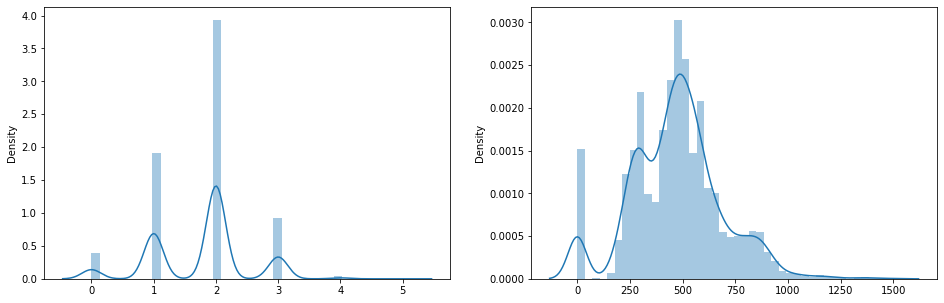

In [35]:
fig, ax = plt.subplots(1,2, figsize =(16, 5))
sns.distplot(x= df['GarageCars'], ax=ax[0])
sns.distplot(x= df['GarageArea'], ax=ax[1])

In [36]:
df['KitchenQual'].value_counts()

TA    1492
Gd    1151
Ex     205
Fa      70
Name: KitchenQual, dtype: int64

We will replace all missing values with the most frequent. 

In [37]:
df['GarageCars'] = df['GarageCars'].fillna(df['GarageCars'].median())
df['GarageArea'] = df['GarageArea'].fillna(df['GarageArea'].median())
df['KitchenQual'] = df['KitchenQual'].fillna('TA')

In [38]:
missing_vals = pd.DataFrame(df.isna().sum(), columns=['Sum'])
missing_vals = missing_vals.sort_values(by = ['Sum'], ascending=False)
missing_vals = missing_vals[missing_vals['Sum']>0]
missing_vals['Percent'] = missing_vals['Sum']/2920*100
missing_vals

,Sum,Percent
GarageYrBlt,159,5.445205


**All DONE!!**

# EDA, outlier analysis and feature engineering
## EDA <a name="paragraph3"></a>
**Check pearson coorrelation matrix for highly coorelations**
* Careful person coorrelation doesn't suit catagorical independent variables. 

In [39]:
train_df = df.iloc[:1460]
train_df['SalePrice'] = train['SalePrice']
train_df.drop(['Id'], axis=1, inplace=True)

In [40]:
test_df = df.iloc[1460:]

<AxesSubplot:>

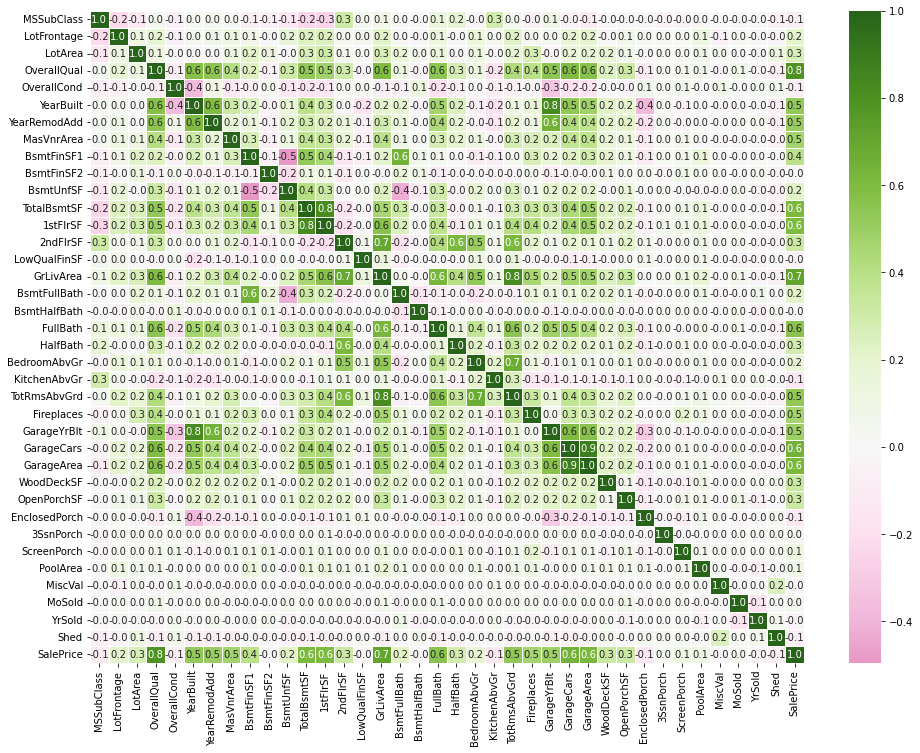

In [41]:
corr_matrix_1 = train_df.corr('pearson')
plt.subplots(figsize=(16, 12))
sns.heatmap(corr_matrix_1, cmap="PiYG", center=0, annot=True, annot_kws={"size": 10}, fmt='.1f', linewidths=0.5)

WRT SalePrice OverallQual is highest at 79% which is a catagorical variable GrLivArea is next at 71% as a continuous variable. GargeCars is next at 64% as a catagorical variable. GarageArea is next at 62%. TotalBsmtSF and 1stFlrSF are both next at 61% and are continuous Full bath is next at 56% as a catagorical.

Other coorelations of note for feature engineering Years:
YearBuilt and GarageYrBlt 83%. YearRemodAdd over 60% with both YearBuilt and GarageYrBlt. Maybe all them all together?

Area: TotalBsmtSF and 1stFlrSF highly coorelated at 82%. GrLivArea and TotRmsAbvGrd are highly coorelated at 83%.

Garage: GarageCars and GarageArea are highly coorelated at 88%.

<AxesSubplot:>

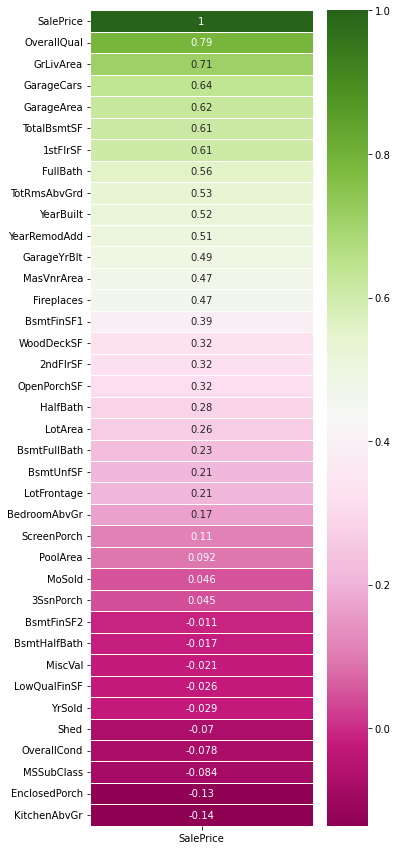

In [42]:
plt.figure(figsize=(5,15))
sns.heatmap(corr_matrix_1[['SalePrice']].sort_values(by=['SalePrice'], ascending=False), cmap="PiYG", annot=True, linewidths=0.5)

### Let's look closely at our target and most significant features <a name="subparagraph1"></a>
**Let's look at our dependent variable and determine if it is normally distributed**

**Are there any obvious outliers?**

**Can we exclude any features due to feature coorelation?**

((array([-3.30513952, -3.04793228, -2.90489705, ...,  2.90489705,
          3.04793228,  3.30513952]),
  array([ 34900,  35311,  37900, ..., 625000, 745000, 755000])),
 (74160.16474519414, 180921.19589041095, 0.9319665641512983))

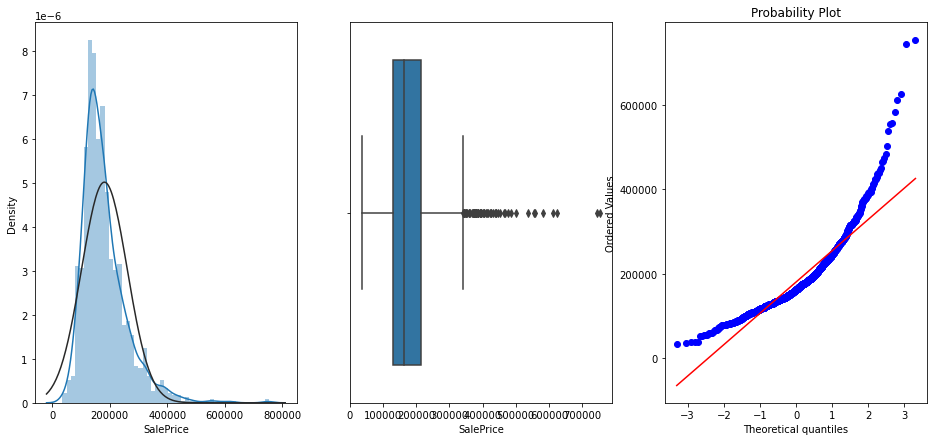

In [43]:
fig, ax = plt.subplots(1,3, figsize =(16, 7))
sns.distplot(train_df['SalePrice'], fit=stats.norm, ax=ax[0])
sns.boxplot(train_df['SalePrice'], ax=ax[1])
stats.probplot(train_df['SalePrice'], plot=ax[2])

In [44]:
print("Skewness: %f" % train_df['SalePrice'].skew())
print("Kurtosis: %f" % train_df['SalePrice'].kurt())
shap_t,shap_p = stats.shapiro(train_df['SalePrice'])
print("Shapiro_Test: %f" % shap_t)
print("Shapiro_Test: %f" % shap_p)

Skewness: 1.882876
Kurtosis: 6.536282
Shapiro_Test: 0.869672
Shapiro_Test: 0.000000


In literature, acceptable values for skewness are between -0.5 and 0.5 while -2 and 2 for Kurtosis.The non-normality of our distribution is also supported by the Shapiro test for normality (p-value really small that allows us to reject the hypotesis of normality). <a name="subtitle1"></a>

SalePrice isn't normally disbriuted. It is positively skewed and does't follow the diagnoal line on the probability plot. When confonting positively skewed disbrituions, log transformations, square root transformations and inverse/reciprocal transformations can be used. Box Cox runs them all dealing with positive values. Yeo-Johnson can handle negative values as well.

**Let's look at our main variables. We are looking for normal distributions, relationships with SalePrice and outliers**

<AxesSubplot:xlabel='OverallQual', ylabel='SalePrice'>

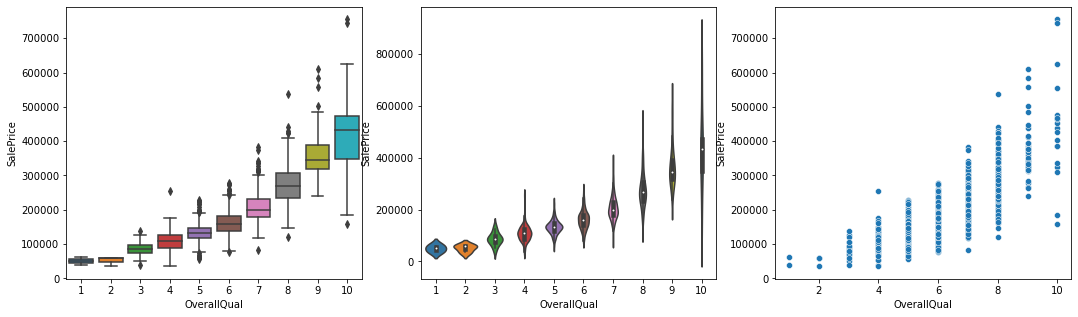

In [45]:
# catagorical variable:  OverallQual
fig, ax = plt.subplots(1,3, figsize =(18, 5))
sns.boxplot(data=train_df, x='OverallQual', y='SalePrice', ax=ax[0])
sns.violinplot(data=train_df, x='OverallQual', y='SalePrice', ax=ax[1])
sns.scatterplot(data=train_df, x='OverallQual', y='SalePrice', ax=ax[2])

* SalePrice seems to increase with OverallQual
* OverallQual is actually at catagorical feature.

In [46]:
train_df['OverallQual'] = train_df['OverallQual'].apply(str)
test_df['OverallQual'] = test_df['OverallQual'].apply(str)

<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

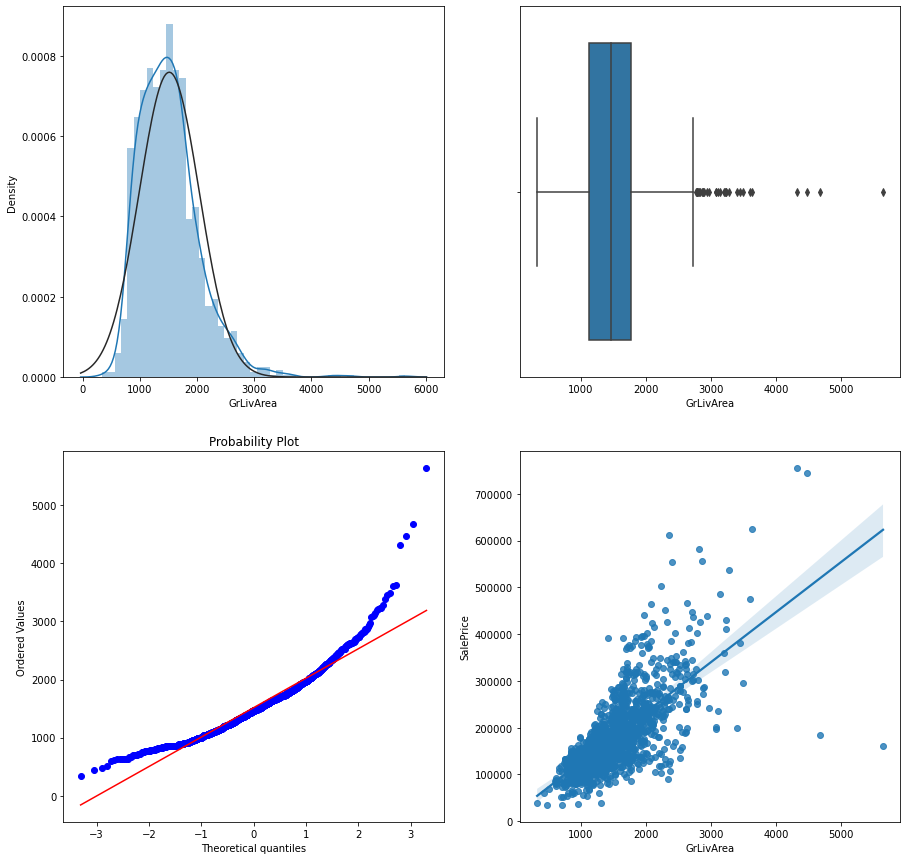

In [47]:
# continuous variable:  GrLivArea
fig, axs = plt.subplots(2,2, figsize=(15, 15))
sns.distplot(train_df['GrLivArea'], fit=stats.norm, ax=axs[0,0])
sns.boxplot(train_df['GrLivArea'], ax=axs[0,1])
stats.probplot(train_df['GrLivArea'], plot=axs[1, 0])
sns.regplot(data=train_df, x='GrLivArea', y='SalePrice', ax=axs[1,1])

In [48]:
print("Skewness: %f" % train_df['GrLivArea'].skew())
print("Kurtosis: %f" % train_df['GrLivArea'].kurt())
shap_t,shap_p = stats.shapiro(train_df['GrLivArea'])
print("Shapiro_Test: %f" % shap_t)
print("Shapiro_Test: %f" % shap_p)

Skewness: 1.366560
Kurtosis: 4.895121
Shapiro_Test: 0.927983
Shapiro_Test: 0.000000


SalePrice seems to increase with GrLivArea

We don't have normally disbrituted data.
In literature, acceptable values for skewness are between -0.5 and 0.5 while -2 and 2 for Kurtosis. The non-normality of our distribution is also supported by the Shapiro test for normality (p-value really small that allows us to reject the hypotesis of normality).

We also have some outliers. I'll drop the two values above 4500 in the future

In [49]:
train_df = train_df[train_df['GrLivArea'] < 4500]

<AxesSubplot:xlabel='GarageCars', ylabel='SalePrice'>

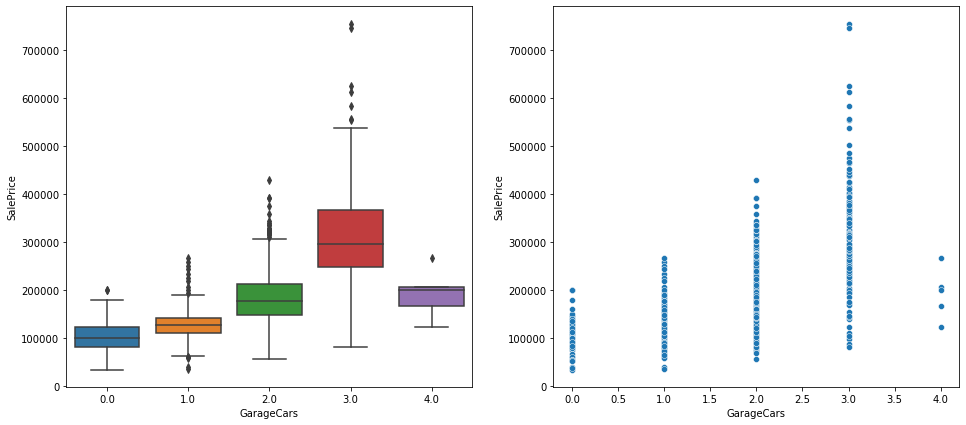

In [50]:
# catagorical variable:  GarageCars
fig, ax = plt.subplots(1,2, figsize =(16, 7))
sns.boxplot(data=train_df, x='GarageCars', y='SalePrice', ax=ax[0])
sns.scatterplot(data=train_df, x='GarageCars', y='SalePrice', ax=ax[1])

In [51]:
train_df['GarageCars'] = train_df['GarageCars'].apply(str)
test_df['GarageCars'] = test_df['GarageCars'].apply(str)

<AxesSubplot:xlabel='GarageArea', ylabel='SalePrice'>

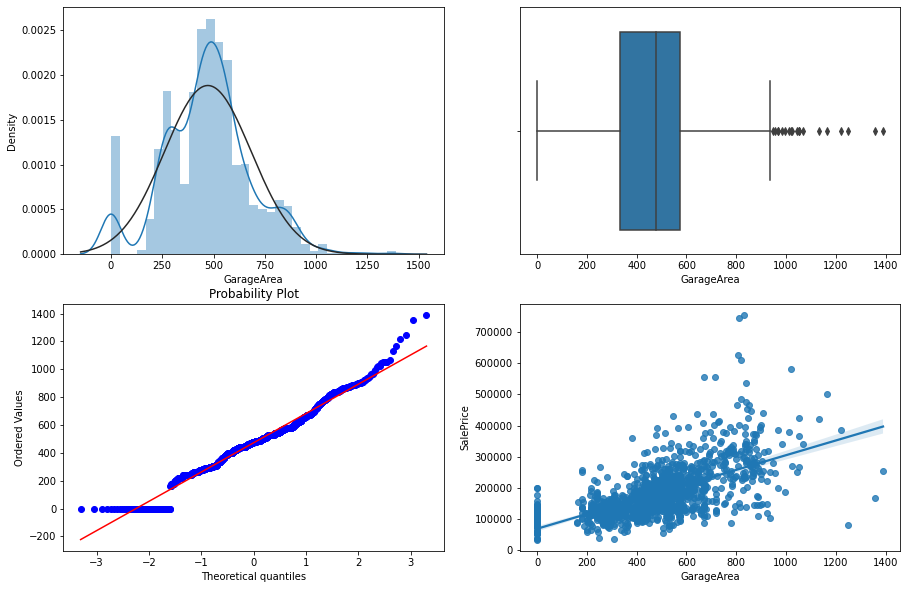

In [52]:
# continuous variable:  GarageArea
fig, axs = plt.subplots(2,2, figsize=(15, 10))
sns.distplot(train_df['GarageArea'], fit=stats.norm, ax=axs[0,0])
sns.boxplot(train_df['GarageArea'], ax=axs[0,1])
stats.probplot(train_df['GarageArea'], plot=axs[1, 0])
sns.regplot(data=train_df, x='GarageArea', y='SalePrice', ax=axs[1,1])

For both Garage Area and GarageCars we have a significant number of 0's. 
You do wonder when you have a large garage area and 4 for GarageCar when's going on? Maybe rural locations? I'm half tempted to get rid of GarageArea > 1230, but will leave it for now

<AxesSubplot:xlabel='TotalBsmtSF', ylabel='SalePrice'>

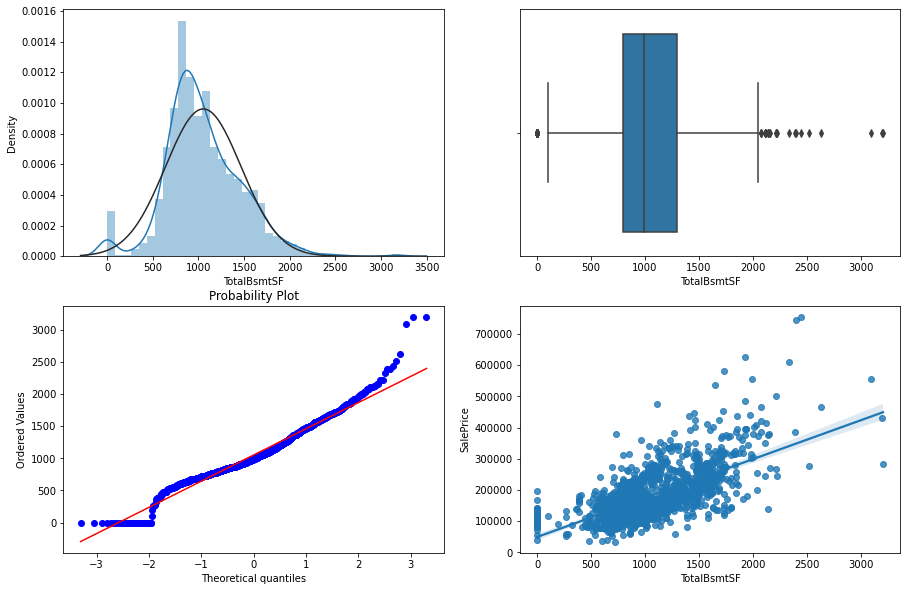

In [53]:
# continuous variable:  TotalBsmtSF
fig, axs = plt.subplots(2,2, figsize=(15, 10))
sns.distplot(train_df['TotalBsmtSF'], fit=stats.norm, ax=axs[0,0])
sns.boxplot(train_df['TotalBsmtSF'], ax=axs[0,1])
stats.probplot(train_df['TotalBsmtSF'], plot=axs[1, 0])
sns.regplot(data=train_df, x='TotalBsmtSF', y='SalePrice', ax=axs[1,1])

<AxesSubplot:xlabel='1stFlrSF', ylabel='SalePrice'>

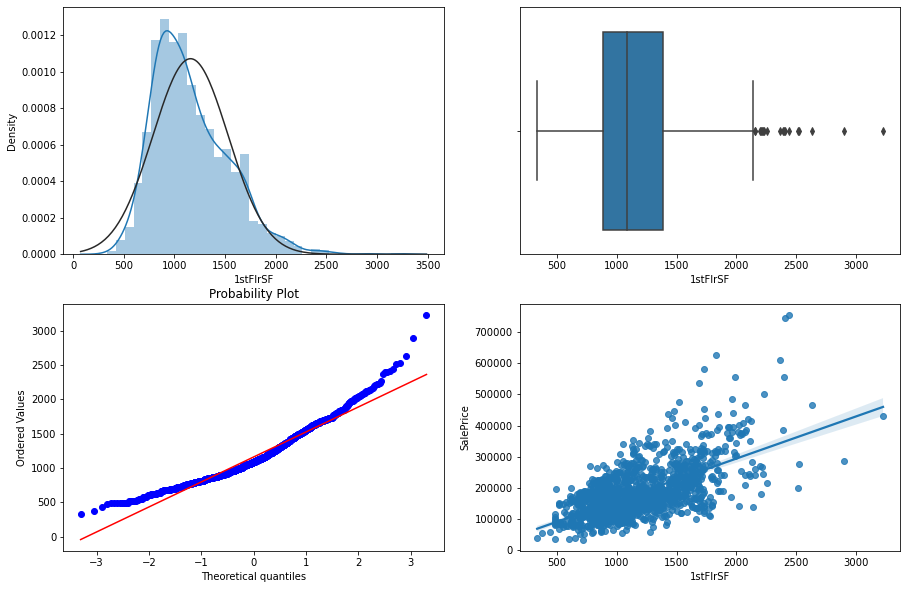

In [54]:
# continuous variable:  1stFlrSF
fig, axs = plt.subplots(2,2, figsize=(15, 10))
sns.distplot(train_df['1stFlrSF'], fit=stats.norm, ax=axs[0,0])
sns.boxplot(train_df['1stFlrSF'], ax=axs[0,1])
stats.probplot(train_df['1stFlrSF'], plot=axs[1, 0])
sns.regplot(data=train_df, x='1stFlrSF', y='SalePrice', ax=axs[1,1])

Again, drop the high value for 1stFlrSF and/or TotalBsmtSF. Looks better to keep 1stFlrSF over TotalBSMTSF due to the lack of 0's present. Will need to transform to normalise.

<AxesSubplot:xlabel='1stFlrSF', ylabel='SalePrice'>

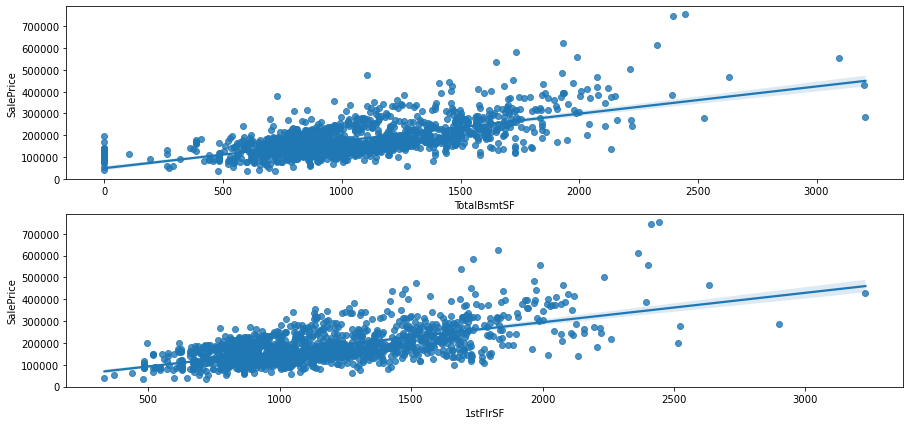

In [55]:
fig, axs = plt.subplots(2, figsize=(15, 7))
sns.regplot(data=train_df, x='TotalBsmtSF', y='SalePrice', ax=axs[0])
sns.regplot(data=train_df, x='1stFlrSF', y='SalePrice', ax=axs[1])

<AxesSubplot:xlabel='FullBath', ylabel='SalePrice'>

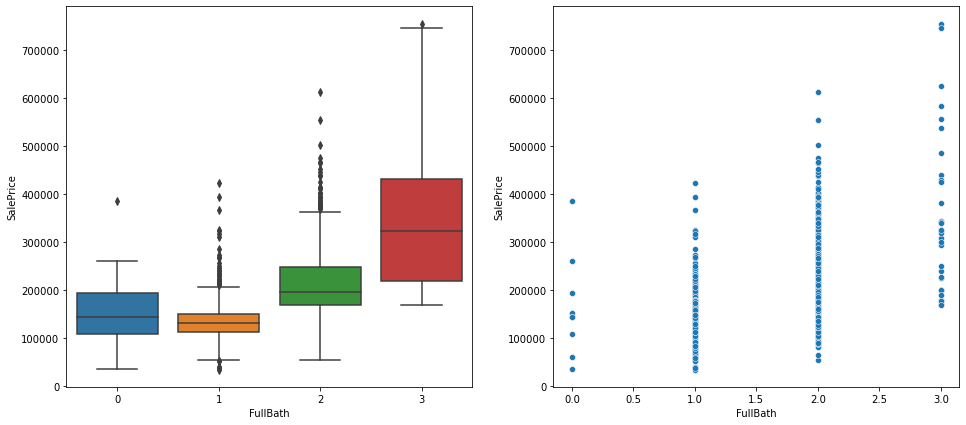

In [56]:
# catagorical variable:  FullBath
fig, ax = plt.subplots(1,2, figsize =(16, 7))
sns.boxplot(data=train_df, x='FullBath', y='SalePrice', ax=ax[0])
sns.scatterplot(data=train_df, x='FullBath', y='SalePrice', ax=ax[1])

### Log Transform SalePrice! <a name="subparagraph2"></a>
[Recall SalePrice was not normally distributed](#subtitle1)

In [57]:
#  Apply the log transform
train_df['SalePrice_log'] = np.log(train_df['SalePrice'])

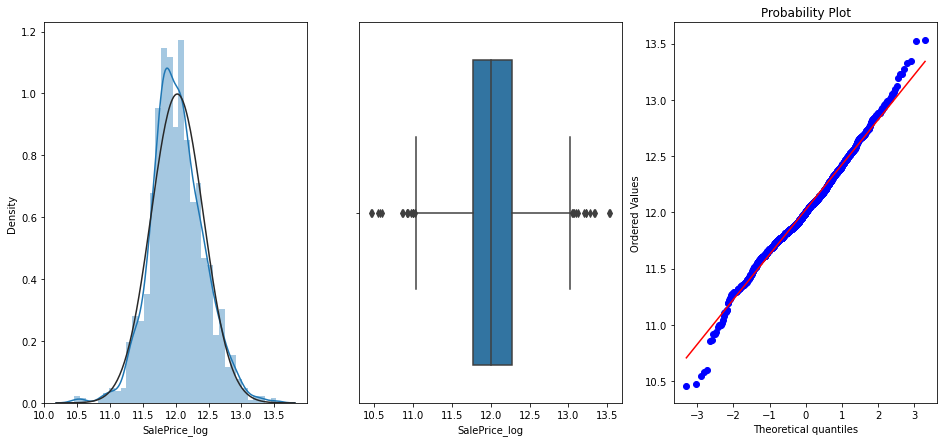

In [58]:
fig, ax = plt.subplots(1,3, figsize =(16, 7))
sns.distplot(train_df['SalePrice_log'], fit=stats.norm, ax=ax[0])
sns.boxplot(train_df['SalePrice_log'], ax=ax[1])
res = stats.probplot(train_df['SalePrice_log'], plot=ax[2])

In [59]:
print("Skewness: %f" % train_df['SalePrice_log'].skew())
print("Kurtosis: %f" % train_df['SalePrice_log'].kurt())
shap_t,shap_p = stats.shapiro(train_df['SalePrice_log'])
print("Shapiro_Test: %f" % shap_t)
print("Shapiro_Test: %f" % shap_p)

Skewness: 0.121568
Kurtosis: 0.804764
Shapiro_Test: 0.991239
Shapiro_Test: 0.000000


In [60]:
train_df['SalePrice'] = train_df['SalePrice_log']
train_df = train_df.drop(['SalePrice_log'], axis=1)

That's some normal data!

### Feature Engineering! <a name="subparagraph3"></a>

Converting non-numeric predictors stored as numbers into string

In [61]:
train_df.select_dtypes(include=[np.float64, np.float32, np.int64, np.int32]).columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'Shed',
       'SalePrice'],
      dtype='object')

**Let's tidy up the years with feature engineering**

YearBuilt: Original construction date

YearRemodAdd: Remodel date (same as construction date if no remodeling or additions)

GarageYrBlt: Year garage was built
* This still have missing vals

<AxesSubplot:xlabel='GarageYrBlt', ylabel='SalePrice'>

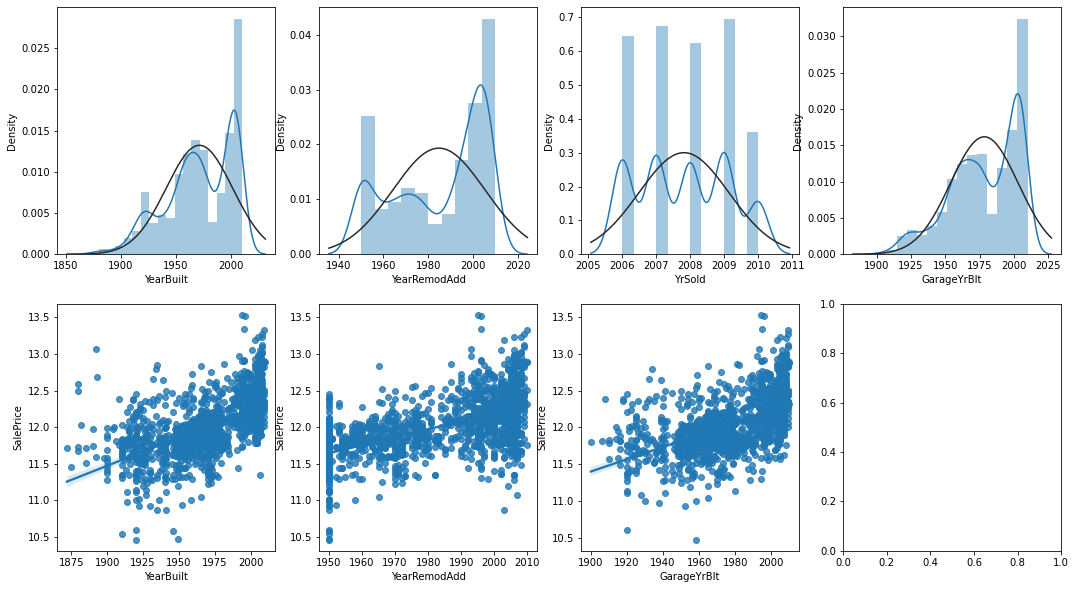

In [62]:
fig, axs = plt.subplots(2,4, figsize=(18, 10))
sns.distplot(train_df['YearBuilt'], fit=stats.norm, ax=axs[0, 0])
sns.distplot(train_df['YearRemodAdd'], fit=stats.norm, ax=axs[0,1])
sns.distplot(train_df['YrSold'], fit=stats.norm, ax=axs[0,2])
sns.distplot(train_df['GarageYrBlt'], fit=stats.norm, ax=axs[0,3])
sns.regplot(data=train_df, x='YearBuilt', y='SalePrice', ax=axs[1,0])
sns.regplot(data=train_df, x='YearRemodAdd', y='SalePrice', ax=axs[1,1])
sns.regplot(data=train_df, x='GarageYrBlt', y='SalePrice', ax=axs[1,2])

In [63]:
train_df['GarageYrBlt'] = train_df['GarageYrBlt'].fillna(train['GarageYrBlt'].min())
train_df['ExtraYears'] = (train_df['YearRemodAdd']-train_df['YearRemodAdd'].min())+(train_df['GarageYrBlt']-train_df['GarageYrBlt'].min())

test_df['GarageYrBlt'] = test_df['GarageYrBlt'].fillna(train_df['GarageYrBlt'].min())
test_df['ExtraYears'] = (test_df['YearRemodAdd']-train_df['YearRemodAdd'].min())+(test_df['GarageYrBlt']-train_df['GarageYrBlt'].min())

train_df.drop(['YearRemodAdd', 'GarageYrBlt'], axis=1, inplace=True)
test_df.drop(['YearRemodAdd', 'GarageYrBlt'], axis=1, inplace=True)

<AxesSubplot:xlabel='YearBuilt', ylabel='SalePrice'>

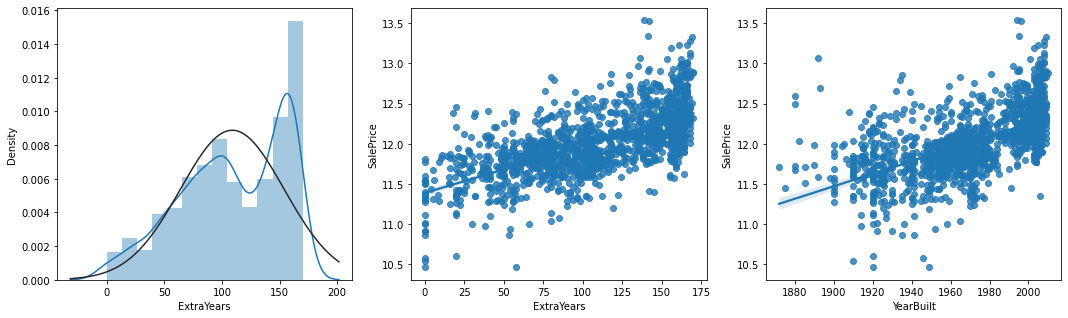

In [64]:
fig, axs = plt.subplots(1,3, figsize=(18, 5))
sns.distplot(train_df['ExtraYears'], fit=stats.norm, ax=axs[0])
sns.regplot(data=train_df, x='ExtraYears', y='SalePrice', ax=axs[1])
sns.regplot(data=train_df, x='YearBuilt', y='SalePrice', ax=axs[2])

Let's look at floor SF and see how they relate to SP
* GrLivArea: Above grade (ground) living area square feet
* 1stFlrSF: First Floor square feet
* 2ndFlrSF: Second floor square feet
* TotalBsmtSF: Total square feet of basement area

<AxesSubplot:xlabel='2ndFlrSF', ylabel='SalePrice'>

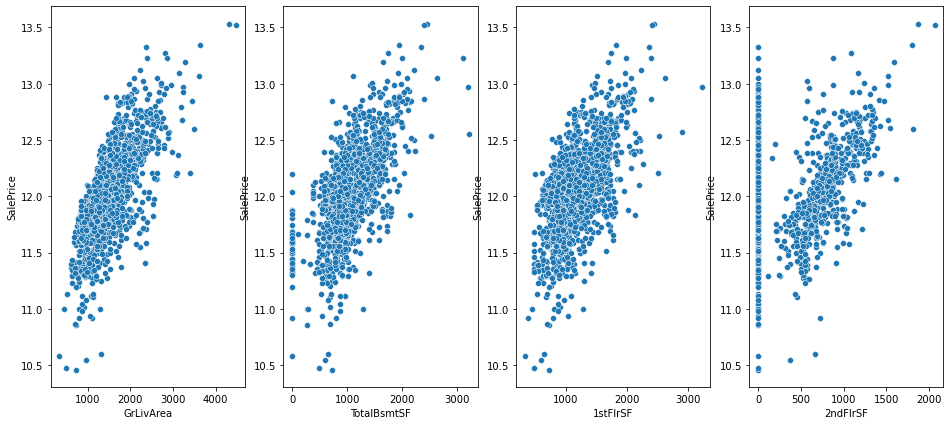

In [65]:
fig, ax = plt.subplots(1,4, figsize =(16, 7))
sns.scatterplot(x=train_df['GrLivArea'], y= train_df['SalePrice'], ax=ax[0])
sns.scatterplot(x=train_df['TotalBsmtSF'], y= train_df['SalePrice'], ax=ax[1])
sns.scatterplot(x=train_df['1stFlrSF'], y= train_df['SalePrice'], ax=ax[2])
sns.scatterplot(x=train_df['2ndFlrSF'], y= train_df['SalePrice'], ax=ax[3])

In [66]:
train_df['OverallSF'] = train_df['GrLivArea']+df['TotalBsmtSF']
train_df['TopFlrSF'] = train_df['1stFlrSF']+train_df['2ndFlrSF']

test_df['OverallSF'] = test_df['GrLivArea']+test_df['TotalBsmtSF']
test_df['TopFlrSF'] = test_df['1stFlrSF']+test_df['2ndFlrSF']

train_df = train_df.drop(['GrLivArea', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF'], axis=1)
test_df = test_df.drop(['GrLivArea', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF'], axis=1)

Let's look at bathrooms and see how they relate to SP
* BsmtFullBath: Basement full bathrooms
* BsmtHalfBath: Basement half bathrooms
* FullBath: Full bathrooms above grade
* HalfBath: Half baths above grade

<AxesSubplot:xlabel='HalfBath', ylabel='SalePrice'>

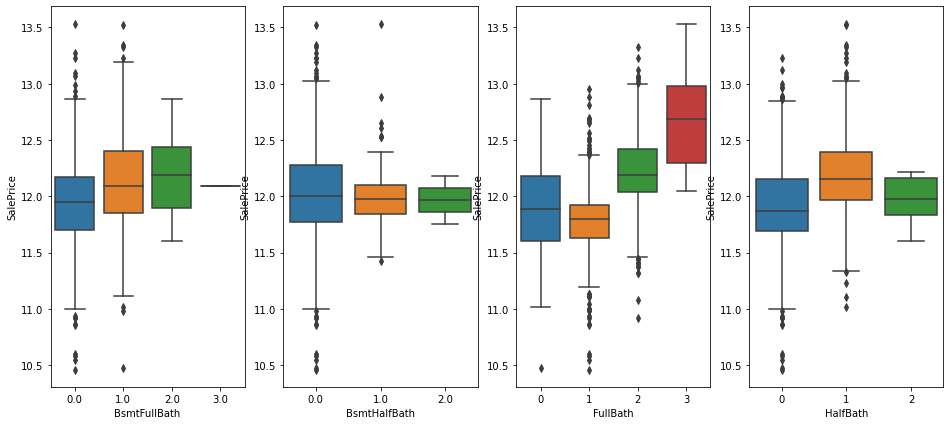

In [67]:
fig, ax = plt.subplots(1,4, figsize =(16, 7))
sns.boxplot(x=train_df['BsmtFullBath'], y= train_df['SalePrice'], ax=ax[0])
sns.boxplot(x=train_df['BsmtHalfBath'], y= train_df['SalePrice'], ax=ax[1])
sns.boxplot(x=train_df['FullBath'], y= train_df['SalePrice'], ax=ax[2])
sns.boxplot(x=train_df['HalfBath'], y= train_df['SalePrice'], ax=ax[3])

In [68]:
train_df['AllFullBath'] = train_df['FullBath']+train_df['BsmtFullBath']
train_df['AllHalfBath'] = train_df['HalfBath']+train_df['BsmtHalfBath']

test_df['AllFullBath'] = test_df['FullBath']+test_df['BsmtFullBath']
test_df['AllHalfBath'] = test_df['HalfBath']+test_df['BsmtHalfBath']

train_df = train_df.drop(['FullBath', 'BsmtFullBath', 'HalfBath', 'BsmtHalfBath'], axis=1)
test_df = test_df.drop(['FullBath', 'BsmtFullBath', 'HalfBath', 'BsmtHalfBath'], axis=1)

### Let's evaluate how we did! 

<AxesSubplot:>

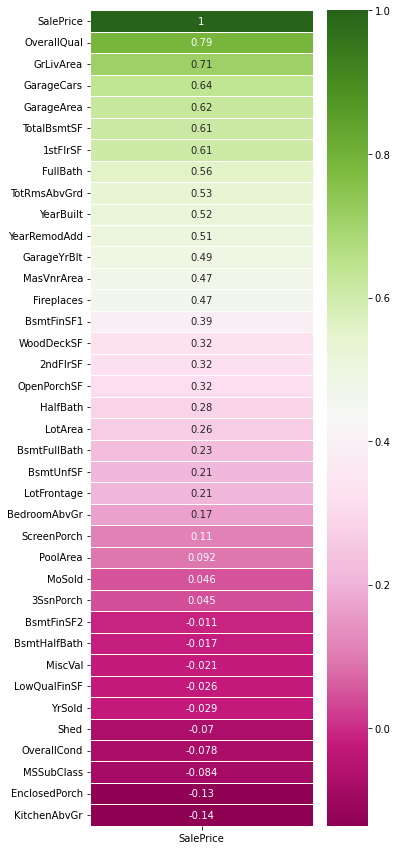

In [69]:
plt.figure(figsize=(5,15))
sns.heatmap(corr_matrix_1[['SalePrice']].sort_values(by=['SalePrice'], ascending=False), cmap="PiYG", annot=True, linewidths=0.5)

<AxesSubplot:>

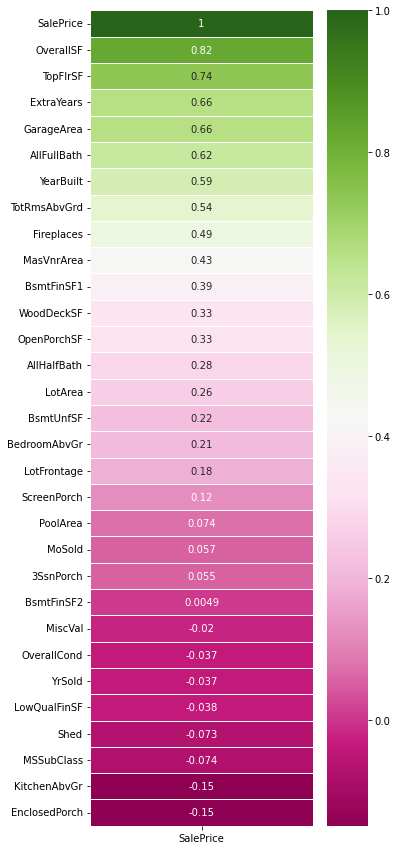

In [70]:
corr_matrix_2 = train_df.corr('pearson')
plt.figure(figsize=(5,15))
sns.heatmap(corr_matrix_2[['SalePrice']].sort_values(by=['SalePrice'], ascending=False), cmap="PiYG", annot=True, linewidths=0.5)

Some features have dropped off due to feature engineering.

### Let's check skewness, see if we need more feature engineering and then transform for normal distributions! <a name="subparagraph4"></a>
Let's define which numerical features are not normally distributed 

In [71]:
numerical_features = train_df.select_dtypes(include=[np.float64, np.float32, np.int64, np.int32]).columns
numerical_features = numerical_features.drop(['SalePrice', 'MSSubClass', 'OverallCond','AllFullBath', 'AllHalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'MoSold', 'YrSold', 'Shed'])
print(numerical_features)

Index(['LotFrontage', 'LotArea', 'YearBuilt', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'LowQualFinSF', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'ExtraYears', 'OverallSF', 'TopFlrSF'],
      dtype='object')


In [72]:
skewed_features = train_df[numerical_features].apply(lambda x: skew(x)).sort_values(ascending=False)
high_skew = skewed_features[abs(skewed_features) > 0.5]
skew_index = high_skew.index
skew_index

Index(['MiscVal', 'PoolArea', 'LotArea', '3SsnPorch', 'LowQualFinSF',
       'BsmtFinSF2', 'ScreenPorch', 'EnclosedPorch', 'MasVnrArea',
       'OpenPorchSF', 'WoodDeckSF', 'TopFlrSF', 'BsmtUnfSF', 'OverallSF',
       'BsmtFinSF1', 'YearBuilt'],
      dtype='object')

Let's look at the first 5 against SalePrice

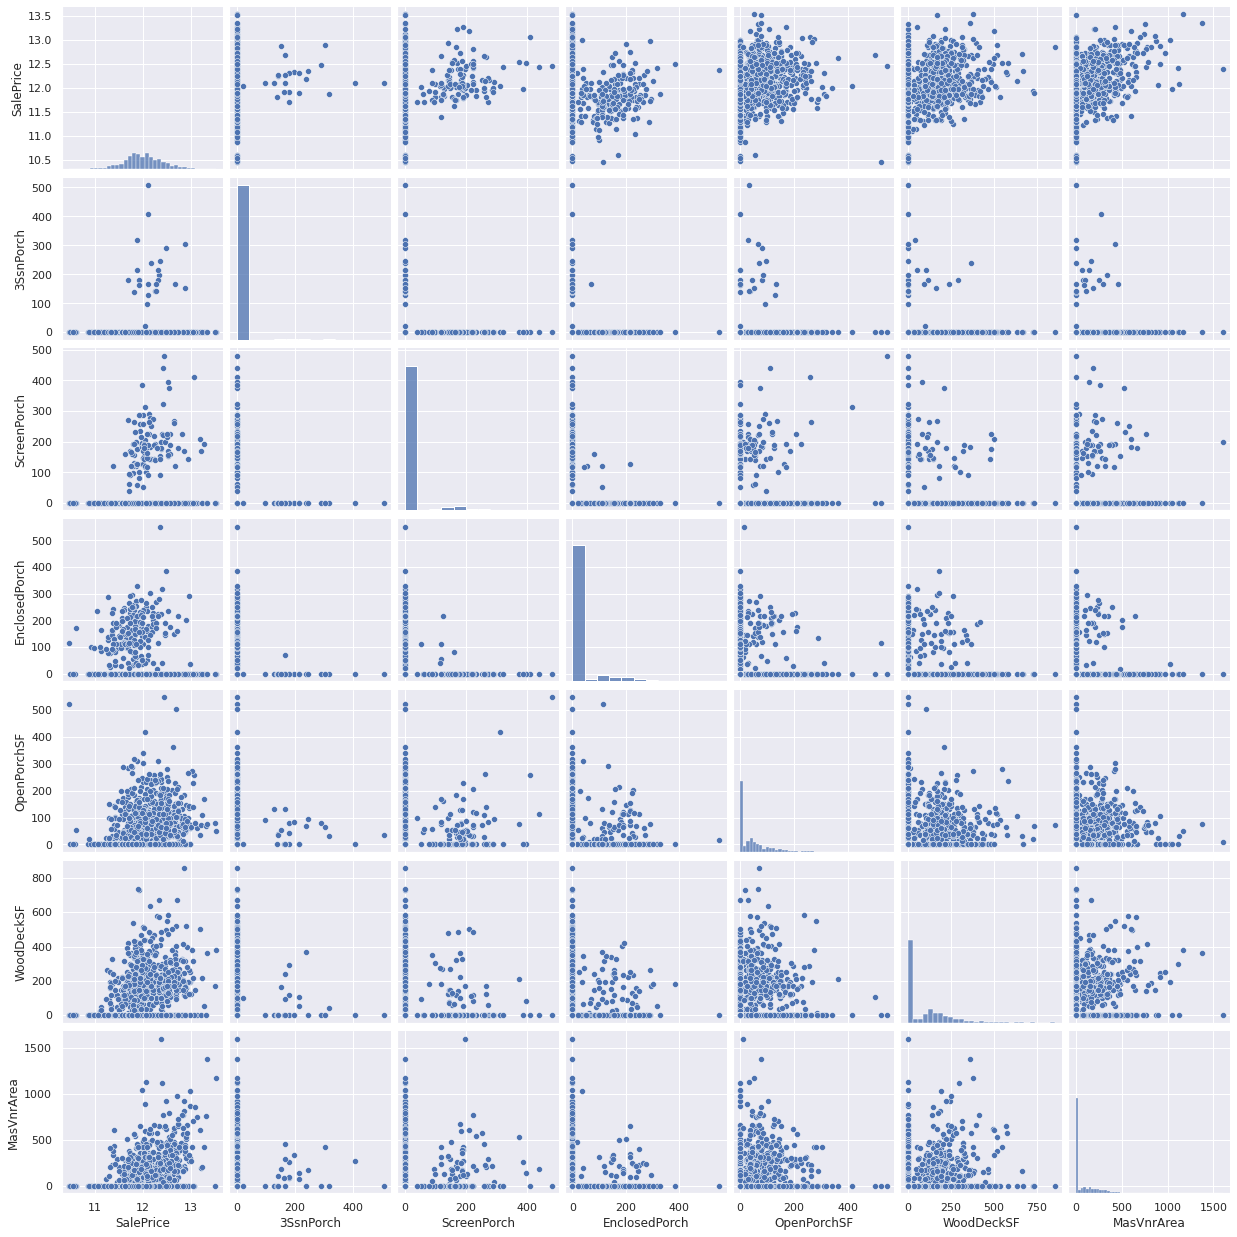

In [73]:
#scatterplot of porch
cols_pair_1 = ['SalePrice', '3SsnPorch', 'ScreenPorch', 'EnclosedPorch', 'OpenPorchSF', 'WoodDeckSF', 'MasVnrArea']
sns.set()
sns.pairplot(train_df[cols_pair_1], size = 2.5)
plt.show();

* Let's combine them all to AllPorchDeck!
* For the remaining I'll use PowerTransformer(Yeo-Johnson) before applying StandardScaler

In [74]:
train_df['OpenPorchSF'].nlargest(3)

1328    547
495     523
583     502
Name: OpenPorchSF, dtype: int64

In [75]:
train_df.drop(index=[495], inplace=True)
train_df = train_df.reset_index(drop=True)

In [76]:
train_df['AllPorchDeck'] = train_df['3SsnPorch']+train_df['ScreenPorch']+train_df['EnclosedPorch']+train_df['OpenPorchSF']+train_df['WoodDeckSF']
test_df['AllPorchDeck'] = test_df['3SsnPorch']+test_df['ScreenPorch']+test_df['EnclosedPorch']+test_df['OpenPorchSF']+test_df['WoodDeckSF']

train_df = train_df.drop(['3SsnPorch', 'ScreenPorch', 'EnclosedPorch', 'OpenPorchSF', 'WoodDeckSF'], axis=1)
test_df = test_df.drop(['3SsnPorch', 'ScreenPorch', 'EnclosedPorch', 'OpenPorchSF', 'WoodDeckSF'], axis=1)

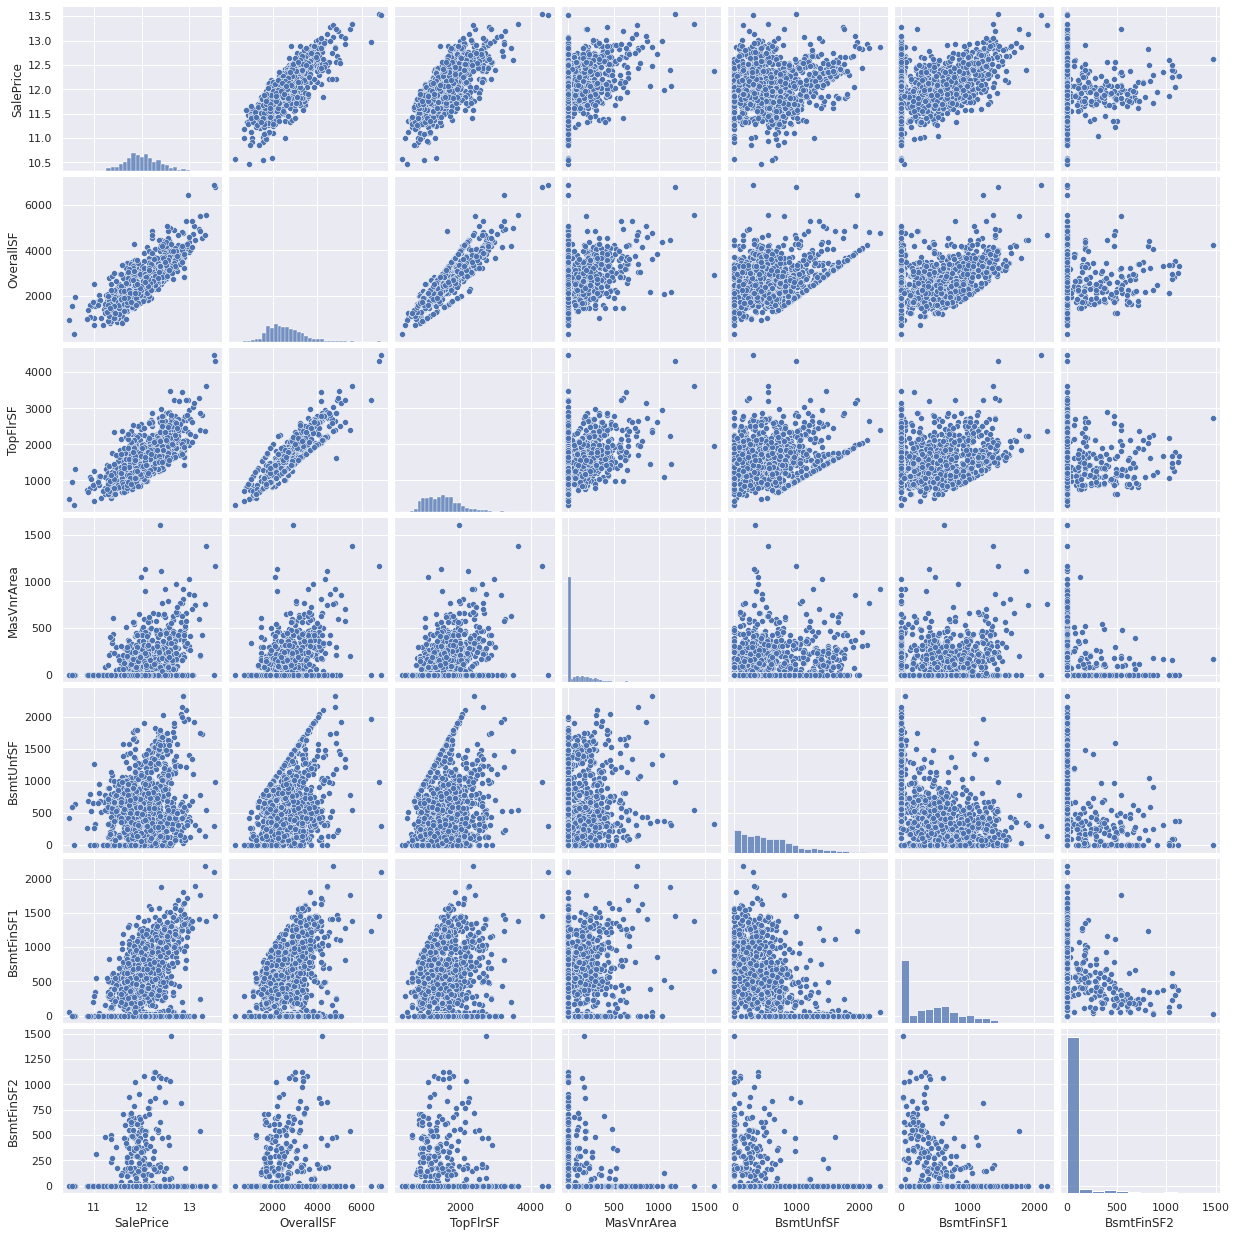

In [77]:
#scatterplot
cols_pair_2 = ['SalePrice', 'OverallSF', 'TopFlrSF', 'MasVnrArea', 'BsmtUnfSF', 'BsmtFinSF1', 'BsmtFinSF2']
sns.set()
sns.pairplot(train_df[cols_pair_2], size = 2.5)
plt.show();

* Create BsmtFinSFAll
* I'll use PowerTransformer(Yeo-Johnson) before applying StandardScaler

In [78]:
train_df['BsmtFinSFAll'] = train_df['BsmtFinSF1']+train_df['BsmtFinSF2']
test_df['BsmtFinSFAll'] = test_df['BsmtFinSF1']+test_df['BsmtFinSF2']

train_df = train_df.drop(['BsmtFinSF1', 'BsmtFinSF2'], axis=1)
test_df = test_df.drop(['BsmtFinSF1', 'BsmtFinSF2'], axis=1)

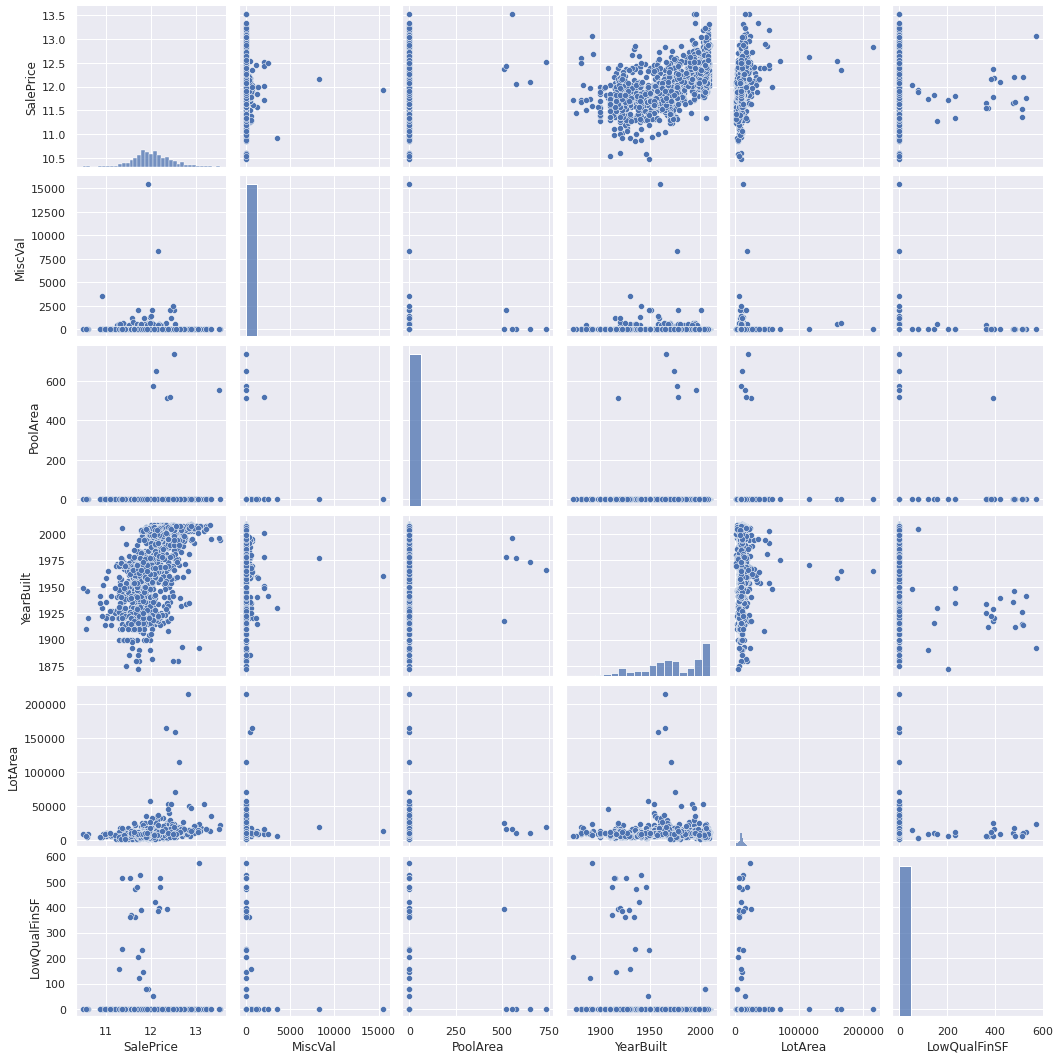

In [79]:
#scatterplot
cols_pair_3 = ['SalePrice', 'MiscVal', 'PoolArea', 'YearBuilt', 'LotArea', 'LowQualFinSF']
sns.set()
sns.pairplot(train_df[cols_pair_3], size = 2.5)
plt.show();

* For MiscVal, PoolArea and LowQualFinSF I will create catagorical features aas I'm not confidering the the amount of non-0 data

In [80]:
#create column for new variable (one is enough because it's a binary categorical feature)
#if > 0 it gets 1, else 0
cols_cat = ['MiscVal', 'PoolArea', 'LowQualFinSF']

for col in cols_cat:
    new_col = 'Has'+col
    train_df[new_col] = 0
    train_df.loc[train_df[col]>0, new_col] = 1
    train_df.drop([col], axis=1, inplace=True)
    test_df[new_col] = 0
    test_df.loc[test_df[col]>0, new_col] = 1
    test_df.drop([col], axis=1, inplace=True)

In [81]:
train_df['MSSubClass'] = train_df['MSSubClass'].apply(str)
train_df['MoSold'] = train_df['MoSold'].apply(str)
train_df['AllFullBath'] = train_df['AllFullBath'].apply(str)
train_df['AllHalfBath'] = train_df['AllHalfBath'].apply(str)
train_df['KitchenAbvGr'] = train_df['KitchenAbvGr'].apply(str)
train_df['OverallCond'] = train_df['OverallCond'].apply(str)
train_df['BedroomAbvGr'] = train_df['BedroomAbvGr'].apply(str)
train_df['TotRmsAbvGrd'] = train_df['TotRmsAbvGrd'].apply(str)
train_df['Fireplaces'] = train_df['Fireplaces'].apply(str)
train_df['YrSold'] = train_df['YrSold'].apply(str)

test_df['MSSubClass'] = test_df['MSSubClass'].apply(str)
test_df['MoSold'] = test_df['MoSold'].apply(str)
test_df['AllFullBath'] = test_df['AllFullBath'].apply(str)
test_df['AllHalfBath'] = test_df['AllHalfBath'].apply(str)
test_df['KitchenAbvGr'] = test_df['KitchenAbvGr'].apply(str)
test_df['OverallCond'] = test_df['OverallCond'].apply(str)
test_df['BedroomAbvGr'] = test_df['BedroomAbvGr'].apply(str)
test_df['TotRmsAbvGrd'] = test_df['TotRmsAbvGrd'].apply(str)
test_df['Fireplaces'] = test_df['Fireplaces'].apply(str)
test_df['YrSold'] = test_df['YrSold'].apply(str)

**I'm going to apply a PowerTransformer on all numerical features excepting SalePrice. Then I can apply the object to the test data and the submission data.**

In [82]:
numerical_features = train_df.select_dtypes(include=[np.float64, np.float32, np.int64, np.int32]).columns
numerical_features = numerical_features.drop(['SalePrice', 'HasPoolArea', 'HasLowQualFinSF', 'HasMiscVal', 'Shed'])
print(numerical_features)

Index(['LotFrontage', 'LotArea', 'YearBuilt', 'MasVnrArea', 'BsmtUnfSF',
       'GarageArea', 'ExtraYears', 'OverallSF', 'TopFlrSF', 'AllPorchDeck',
       'BsmtFinSFAll'],
      dtype='object')


In [83]:
skewed_features = train_df[numerical_features].apply(lambda x: skew(x)).sort_values(ascending=False)
high_skew = skewed_features[abs(skewed_features) > 0.5]
skew_index = high_skew.index
skew_index

Index(['LotArea', 'MasVnrArea', 'AllPorchDeck', 'TopFlrSF', 'BsmtUnfSF',
       'OverallSF', 'BsmtFinSFAll', 'YearBuilt'],
      dtype='object')

# OneHotEncoding
### OneHotEncoding catagorical features! <a name="paragraph4"></a>
I orginally did pandas get dummies however applying that to the test data was a problem for the model. Essentially I didn't maintain the same number of columns/features. So we'll go with OneHotEncoding!


In [84]:
# I will not use One-hot encoding for Catboost as it isn't recommended
train = train_df

In [85]:
categorical_features = train_df.select_dtypes(include = ["object"]).columns
print(categorical_features)

Index(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces',
       'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageCars', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MoSold', 'YrSold',
       'SaleType', 'SaleCondition', 'AllFullBath', 'AllHalfBath'],
      dtype='object')


In [86]:
print(train_df.shape)
print(test_df.shape)

(1457, 70)
(1459, 70)


In [87]:
missing_vals = test_df.isnull().sum()
missing_vals = missing_vals[missing_vals>0]
missing_vals

Series([], dtype: int64)

In [88]:
# Reset the index after dropping some outliers
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [89]:
# Instantiate the OneHotEncoder Object
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(handle_unknown='ignore', sparse = False, )
# Apply ohe on data
ohe.fit(train_df[categorical_features])
cat_ohe = ohe.transform(train_df[categorical_features])

#Create a Pandas DataFrame of the hot encoded column
ohe_df = pd.DataFrame(cat_ohe, columns = ohe.get_feature_names(input_features = categorical_features))


In [90]:
train_df = train_df.drop(categorical_features, axis=1)

In [91]:
#concat with original data and drop original columns
train_df = pd.concat([train_df, ohe_df], axis=1)

In [92]:
print(train_df.shape)
print(test_df.shape)

(1457, 371)
(1459, 70)


In [93]:
correlations_final = train_df.corrwith(train_df.SalePrice)
correlations_final = correlations_final.abs().sort_values(ascending=False)
cols_final = list(train_df.corrwith(train_df.SalePrice)[train_df.corrwith(train_df.SalePrice).abs()>0.4].index)

### Let's do one final correlation evaluation! 

<AxesSubplot:>

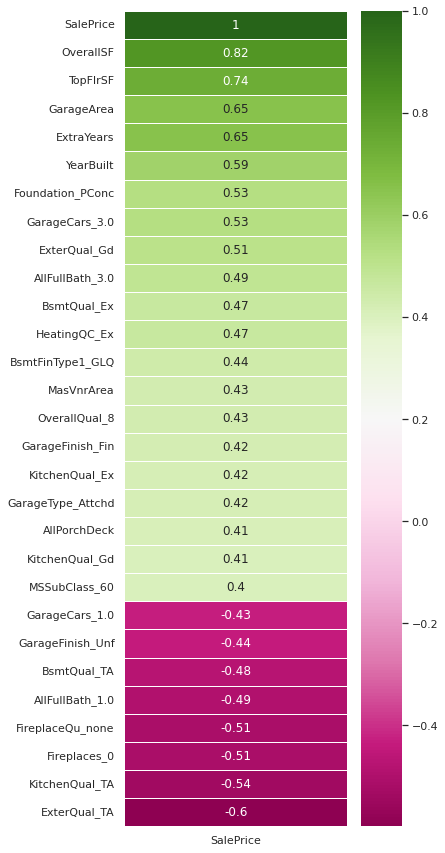

In [94]:
corr_matrix_3 = train_df[cols_final].corr('pearson')
plt.figure(figsize=(5,15))
sns.heatmap(corr_matrix_3[['SalePrice']].sort_values(by=['SalePrice'], ascending=False), cmap="PiYG", annot=True, linewidths=0.5)

<AxesSubplot:>

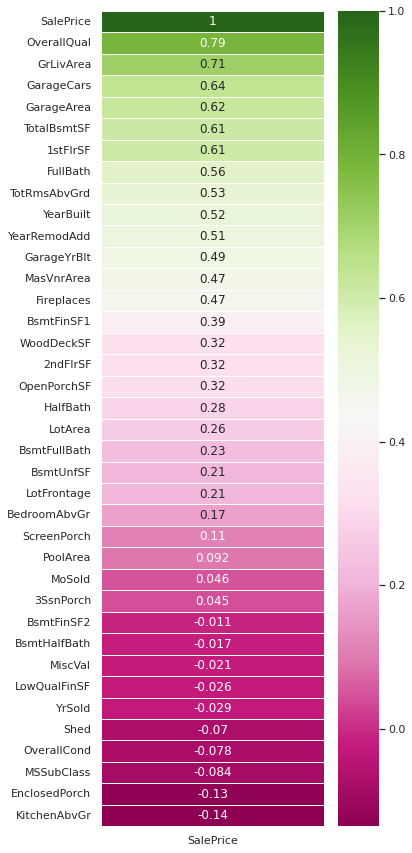

In [95]:
plt.figure(figsize=(5,15))
sns.heatmap(corr_matrix_1[['SalePrice']].sort_values(by=['SalePrice'], ascending=False), cmap="PiYG", annot=True, linewidths=0.5)

Some of the encoded catagorical features are showing high pearson coorelations!!! Some high impact on the negative side too. 

# Inital Assessment of Models
### Survey of regression algorithms <a name="paragraph5"></a>

In [96]:
# Import the libraries needed
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer, StandardScaler, RobustScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score, KFold

In [97]:
y = train_df['SalePrice']

In [98]:
X = train_df.drop(['SalePrice'], axis=1)

In [99]:
skew_index

Index(['LotArea', 'MasVnrArea', 'AllPorchDeck', 'TopFlrSF', 'BsmtUnfSF',
       'OverallSF', 'BsmtFinSFAll', 'YearBuilt'],
      dtype='object')

In [100]:
pt_x= PowerTransformer(method='yeo-johnson').fit(X[numerical_features])

X[numerical_features]  = pt_x.transform(X[numerical_features])

In [101]:
#rs_x= RobustScaler().fit(X[numerical_features])
Stdsc_x= StandardScaler().fit(X[numerical_features])

X[numerical_features]  = Stdsc_x.transform(X[numerical_features])
#X[numerical_features]  = rs_x.transform(X[numerical_features])

In [102]:
X.head()

,LotFrontage,LotArea,YearBuilt,MasVnrArea,BsmtUnfSF,GarageArea,Shed,ExtraYears,OverallSF,TopFlrSF,AllPorchDeck,BsmtFinSFAll,HasMiscVal,HasPoolArea,HasLowQualFinSF,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_Pave,Alley_none,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,OverallQual_1,OverallQual_10,OverallQual_2,OverallQual_3,OverallQual_4,OverallQual_5,OverallQual_6,OverallQual_7,OverallQual_8,OverallQual_9,OverallCond_1,OverallCond_2,OverallCond_3,OverallCond_4,OverallCond_5,OverallCond_6,OverallCond_7,OverallCond_8,OverallCond_9,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtQual_none,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtCond_none,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_none,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType1_none,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,BsmtFinType2_none,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,BedroomAbvGr_0,BedroomAbvGr_1,BedroomAbvGr_2,BedroomAbvGr_3,BedroomAbvGr_4,BedroomAbvGr_5,BedroomAbvGr_6,BedroomAbvGr_8,KitchenAbvGr_0,Kitche

In [103]:
X.describe()

,LotFrontage,LotArea,YearBuilt,MasVnrArea,BsmtUnfSF,GarageArea,Shed,ExtraYears,OverallSF,TopFlrSF,AllPorchDeck,BsmtFinSFAll,HasMiscVal,HasPoolArea,HasLowQualFinSF,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_Pave,Alley_none,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,OverallQual_1,OverallQual_10,OverallQual_2,OverallQual_3,OverallQual_4,OverallQual_5,OverallQual_6,OverallQual_7,OverallQual_8,OverallQual_9,OverallCond_1,OverallCond_2,OverallCond_3,OverallCond_4,OverallCond_5,OverallCond_6,OverallCond_7,OverallCond_8,OverallCond_9,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtQual_none,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtCond_none,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_none,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType1_none,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,BsmtFinType2_none,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,BedroomAbvGr_0,BedroomAbvGr_1,BedroomAbvGr_2,BedroomAbvGr_3,BedroomAbvGr_4,BedroomAbvGr_5,BedroomAbvGr_6,BedroomAbvGr_8,KitchenAbvGr_0,Kitche

In [104]:
# 10 fold cross validatoin
kf = KFold(n_splits=10)

In [105]:
from sklearn.linear_model import BayesianRidge, ElasticNet
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Modeling step Test differents algorithms 
random_state = 2
models = []

models.append(BayesianRidge())
models.append(ElasticNet(random_state=random_state))
models.append(CatBoostRegressor(random_state=random_state, verbose=False))
models.append(RandomForestRegressor(random_state=random_state))
models.append(XGBRegressor(random_state=random_state))
models.append(DecisionTreeRegressor(random_state=random_state))
models.append(GradientBoostingRegressor(random_state=random_state))

In [106]:
# RMSE: tells us how far apart the predicted values are from the observed values in a dataset, on average. The lower the RMSE, the better a model fits a dataset.
cv_results_rmse = []
for model in models :
    cv_results_rmse.append(np.sqrt(-cross_val_score(model, X, y = y, scoring="neg_mean_squared_error", cv=kf, n_jobs=2)))

cv_means_rmse = []
for cv_result_rmse in cv_results_rmse:
    cv_means_rmse.append(cv_result_rmse.mean())

cv = pd.DataFrame({"CrossValMeans rmse":cv_means_rmse, "Algorithm":["Bayesian","ElasticNet","CatBoost","RandomForest",
"XGB","DecisionTree","GradientBoost"]})

In [107]:
# R2: tells us the proportion of the variance in the response variable of a regression model that can be explained by the predictor variables. 
# This value ranges from 0 to 1. The higher the R2 value, the better a model fits a dataset.
cv_results_r2 = []
for model in models :
    cv_results_r2.append(cross_val_score(model, X, y = y, scoring="r2", cv=kf, n_jobs=2))

cv_means_r2 = []
for cv_result_r2 in cv_results_r2:
    cv_means_r2.append(cv_result_r2.mean())

cv["CrossValMeans r2"] = cv_means_r2

In [108]:
cv

,CrossValMeans rmse,Algorithm,CrossValMeans r2
0,0.112663,Bayesian,0.918676
1,0.397069,ElasticNet,-0.007274
2,0.115102,CatBoost,0.915068
3,0.140663,RandomForest,0.873453
4,0.133291,XGB,0.885538
5,0.201593,DecisionTree,0.739217
6,0.127230,GradientBoost,0.896484


(0.7, 0.95)

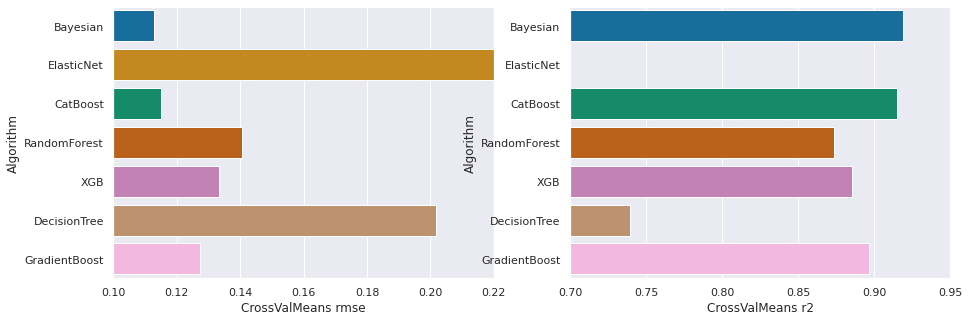

In [109]:
fig, axs = plt.subplots(1,2, figsize=(15, 5))
sns.barplot(x="CrossValMeans rmse",y="Algorithm",data = cv, palette="colorblind", orient='h', ax=axs[0])
sns.barplot(x="CrossValMeans r2",y="Algorithm",data = cv, palette="colorblind", orient='h', ax=axs[1])
axs[0].set_xlim([0.1, 0.22])
axs[1].set_xlim([0.7, 0.95])

**Let's build regression models with Bayesian and Catboost algorithms**

# Optimise Best Models
### Hyperparameter tuning of down selected algorithms <a name="paragraph6"></a>

In [110]:
X2 = train_df.drop(['SalePrice'], axis=1)

# Partition the dataset in train + validation sets
X2_train, X2_test, y_train, y_test = train_test_split(X2, y, test_size = 0.2, random_state = 0)
print("X_train : " + str(X2_train.shape))
print("X_test : " + str(X2_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

X_train : (1165, 370)
X_test : (292, 370)
y_train : (1165,)
y_test : (292,)


In [111]:
pt_x2= PowerTransformer(method='yeo-johnson').fit(X2_train[numerical_features])

X2_train[numerical_features]  = pt_x2.transform(X2_train[numerical_features])
X2_test[numerical_features]  = pt_x2.transform(X2_test[numerical_features])

In [112]:
#rs_x2= RobustScaler().fit(X2_train[numerical_features])
Stdsc_x2= StandardScaler().fit(X2_train[numerical_features])

X2_train[numerical_features]  = Stdsc_x.transform(X2_train[numerical_features])
X2_test[numerical_features]  = Stdsc_x.transform(X2_test[numerical_features])
#X2_train[numerical_features]  = rs_x2.transform(X2_train[numerical_features])
#X2_test[numerical_features]  = rs_x2.transform(X2_test[numerical_features])

In [113]:
from sklearn.model_selection import GridSearchCV

bay_params = {'alpha_init':[1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.9],
              'lambda_init': [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-9]}

BR = GridSearchCV(estimator=BayesianRidge(), 
                  param_grid = bay_params, 
                  cv = 10, 
                  n_jobs=2)

BR.fit(X2_train,y_train)

GridSearchCV(cv=10, estimator=BayesianRidge(), n_jobs=2,
             param_grid={'alpha_init': [1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.9],
                         'lambda_init': [0.1, 0.01, 0.001, 0.0001, 1e-05, 1e-06,
                                         1e-09]})

In [114]:
print(BR.best_params_)
print(BR.best_estimator_)
print(BR.best_score_)

{'alpha_init': 1, 'lambda_init': 0.1}
BayesianRidge(alpha_init=1, lambda_init=0.1)
0.9182891165706606


In [115]:
BR = BayesianRidge(alpha_init=1, lambda_init=0.1)
BR.fit(X2_train,y_train)
y_test_BR=BR.predict(X2_test)
y_train_BR = BR.predict(X2_train)

In [116]:
print('-'*10+'Model'+'-'*10)
print('R square Accuracy: ',r2_score(y_test,y_test_BR))
print('Mean Squared Error Accuracy: ',mean_squared_error(y_test,y_test_BR))

----------Model----------
R square Accuracy:  0.9246548842257543
Mean Squared Error Accuracy:  0.01222248343201575


BayesianRidge picked 370 features and eliminated the other 0 features


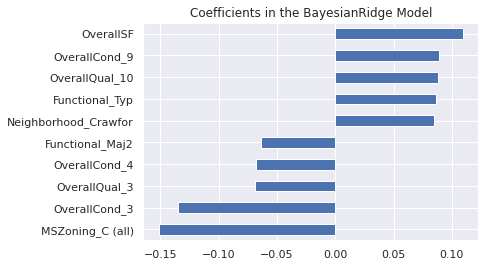

In [117]:
coefs_BR = pd.Series(BR.coef_, index = X2_train.columns)
print("BayesianRidge picked " + str(sum(coefs_BR != 0)) + " features and eliminated the other " +  str(sum(coefs_BR == 0)) + " features")
imp_coefs_BR = pd.concat([coefs_BR.sort_values().head(5), coefs_BR.sort_values().tail(5)])
imp_coefs_BR.plot(kind = "barh")
plt.title("Coefficients in the BayesianRidge Model")
plt.show()

In [118]:
CB = CatBoostRegressor(verbose=False)

CB.fit(X2_train,y_train)
y_test_CB=CB.predict(X2_test)
y_train_CB = CB.predict(X2_train)

In [119]:
print('-'*10+'Model'+'-'*10)
print('R square Accuracy: ',r2_score(y_test,y_test_CB))
print('Mean Squared Error Accuracy: ',mean_squared_error(y_test,y_test_CB))

----------Model----------
R square Accuracy:  0.9198633251749555
Mean Squared Error Accuracy:  0.012999770061813886


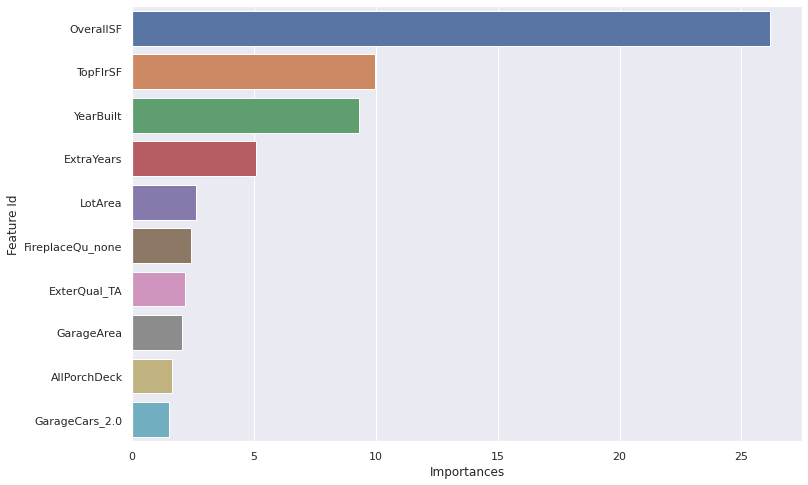

In [120]:
feat_imp = CB.get_feature_importance(prettified=True)
plt.figure(figsize = (12,8))
sns.barplot(feat_imp['Importances'][:20],feat_imp['Feature Id'][:10], orient = 'h')
plt.show()

# Predict SalePrice
### Predict test dataframe SalePrice <a name="paragraph7"></a>

In [121]:
print(test_df.shape)
test_df.head()

(1459, 70)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtUnfSF,Heating,HeatingQC,CentralAir,Electrical,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MoSold,YrSold,SaleType,SaleCondition,Shed,ExtraYears,OverallSF,TopFlrSF,AllFullBath,AllHalfBath,AllPorchDeck,BsmtFinSFAll,HasMiscVal,HasPoolArea,HasLowQualFinSF
0,1461,20,RH,80.0,11622,Pave,none,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,LwQ,270.0,GasA,TA,Y,SBrkr,2,1,TA,5,Typ,0,none,Attchd,Unf,1.0,730.0,TA,TA,Y,none,MnPrv,6,2010,WD,Normal,0,72.0,1778.0,896,1.0,0.0,260,612.0,0,0,0
1,1462,20,RL,81.0,14267,Pave,none,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,Unf,406.0,GasA,TA,Y,SBrkr,3,1,Gd,6,Typ,0,none,Attchd,Unf,1.0,312.0,TA,TA,Y,none,none,6,2010,WD,Normal,0,66.0,2658.0,1329,1.0,1.0,429,923.0,1,0,0
2,1463,60,RL,74.0,13830,Pave,none,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,Unf,137.0,GasA,Gd,Y,SBrkr,3,1,TA,6,Typ,1,TA,Attchd,Fin,2.0,482.0,TA,TA,Y,none,MnPrv,3,2010,WD,Normal,0,145.0,2557.0,1629,2.0,1.0,246,791.0,0,0,0
3,1464,60,RL,78.0,9978,Pave,none,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,Unf,324.0,GasA,Ex,Y,SBrkr,3,1,Gd,7,Typ,1,Gd,Attchd,Fin,2.0,470.0,TA,TA,Y,none,none,6,2010,WD,Normal,0,146.0,2530.0,1604,2.0,1.0,396,602.0,0,0,0
4,1465,120,RL,43.0,5005,Pave,none,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,Unf,1017.0,GasA,Ex,Y,SBrkr,2,1,Gd,5,Typ,0,none,Attchd,RFn,2.0,506.0,TA,TA,Y,none,none,1,2010,WD,Normal,0,134.0,2560.0,1280,2.0,0.0,226,263.0,0,0,0


In [122]:
# The following code is for your test dataframe after training and testing on df dataframe
# Apply ohe on new dataframe
cat_ohe_test = ohe.transform(test_df[categorical_features])
#Create a Pandas DataFrame of the hot encoded column
ohe_df_test = pd.DataFrame(cat_ohe_test, columns = ohe.get_feature_names(input_features = categorical_features))

test_df = test_df.drop(categorical_features, axis=1)
#concat with original data and drop original columns
test_df = pd.concat([test_df, ohe_df_test], axis=1)

In [123]:
print(train_df.shape)
print(test_df.shape)

(1457, 371)
(1459, 371)


In [124]:
test_df[numerical_features]  = pt_x.transform(test_df[numerical_features])
test_df[numerical_features]  = Stdsc_x.transform(test_df[numerical_features])

In [125]:
test_df.head()

,Id,LotFrontage,LotArea,YearBuilt,MasVnrArea,BsmtUnfSF,GarageArea,Shed,ExtraYears,OverallSF,TopFlrSF,AllPorchDeck,BsmtFinSFAll,HasMiscVal,HasPoolArea,HasLowQualFinSF,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_Pave,Alley_none,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,OverallQual_1,OverallQual_10,OverallQual_2,OverallQual_3,OverallQual_4,OverallQual_5,OverallQual_6,OverallQual_7,OverallQual_8,OverallQual_9,OverallCond_1,OverallCond_2,OverallCond_3,OverallCond_4,OverallCond_5,OverallCond_6,OverallCond_7,OverallCond_8,OverallCond_9,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtQual_none,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtCond_none,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_none,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType1_none,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,BsmtFinType2_none,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,BedroomAbvGr_0,BedroomAbvGr_1,BedroomAbvGr_2,BedroomAbvGr_3,BedroomAbvGr_4,BedroomAbvGr_5,BedroomAbvGr_6,BedroomAbvGr_8,KitchenAbvGr_0,Kit

In [126]:
test_id = test_df['Id']
test_df = test_df.drop(['Id'], axis=1)

In [127]:
submission = pd.DataFrame(test_id, columns=['Id']) 

In [128]:
sample_submission['SalePrice_BayesianRidge_log']=BR.predict(test_df)
sample_submission['SalePrice_BayesianRidge'] = np.exp(sample_submission.SalePrice_BayesianRidge_log)

In [129]:
sample_submission['SalePrice_CatBoost_log']=CB.predict(test_df)
sample_submission['SalePrice_Catboost'] =np.exp(sample_submission.SalePrice_CatBoost_log)
submission['SalePrice'] =np.exp(sample_submission.SalePrice_CatBoost_log)

In [130]:
sample_submission.head()

,Id,SalePrice,SalePrice_BayesianRidge_log,SalePrice_BayesianRidge,SalePrice_CatBoost_log,SalePrice_Catboost
0,1461,169277.052498,11.646580,114299.795054,11.727172,123892.788210
1,1462,187758.393989,11.966467,157387.611557,11.975010,158737.981579
2,1463,183583.683570,12.133642,186026.002029,12.184535,195738.457939
3,1464,179317.477511,12.207658,200317.233061,12.209386,200663.701313
4,1465,150730.079977,12.146097,188357.525893,12.140881,187377.635419


<AxesSubplot:xlabel='SalePrice_Catboost', ylabel='SalePrice'>

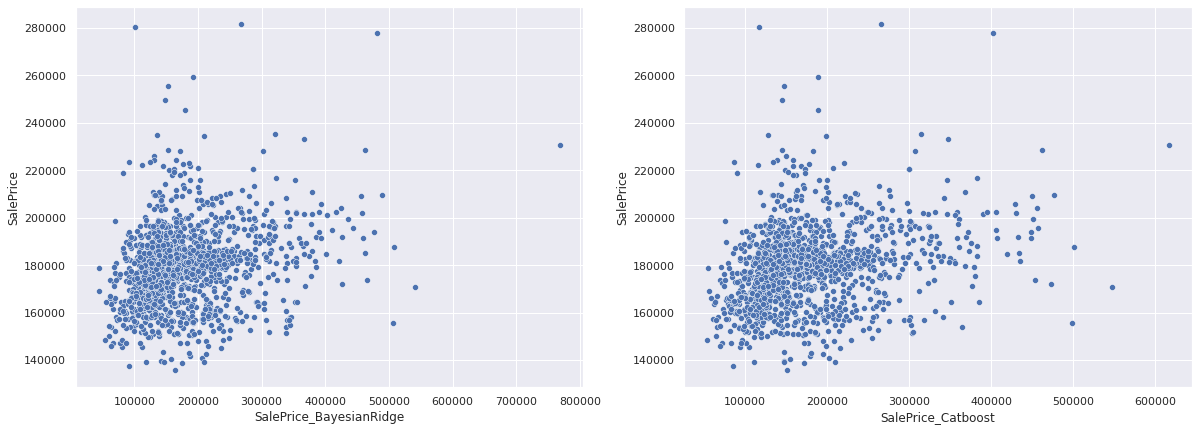

In [131]:
fig, ax = plt.subplots(1, 2, figsize =(20, 7))
sns.scatterplot(x= sample_submission['SalePrice_BayesianRidge'], y=sample_submission['SalePrice'], ax=ax[0])
sns.scatterplot(x= sample_submission['SalePrice_Catboost'], y=sample_submission['SalePrice'], ax=ax[1])

In [132]:
submission.to_csv('submission.csv', index=False)